In [1225]:
from warnings import simplefilter

import altair as alt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, SVG, IFrame, Image, Video, display
from matplotlib import cm, colors
from scipy import stats
from scipy.stats import norm
from src.data import gdf_dic
from src.env import EnvVar
from src.maps import map_altair
from src.utils import discretisation, loadgpd

simplefilter(action="ignore", category=FutureWarning)


alt.renderers.set_embed_options(
    padding={"left": 100, "right": 100, "bottom": 20, "top": 20}, actions=False
)

RendererRegistry.enable('default')

In [1226]:
# Data INSEE

from pynsee.utils.init_conn import init_conn

init_conn(
    insee_key="NzZfjOPcoI0C9gkeMyu0SH5ChW8a",
    insee_secret="zsvYnCV8BHcGX_1CWnR7YU3EkKIa",
)

from pynsee.localdata import (
    get_geo_list,
    get_local_data,
    get_local_metadata,
    get_nivgeo_list,
)

metadata = get_local_metadata()
metadata = metadata.query("DATASET_VERSION=='GEO2021RP2018'")


data_all_france = get_local_data(
    dataset_version="GEO2021RP2018",
    variables="CS1_6",
    nivgeo="DEP",
)

csp_fr = data_all_france.query("CS1_6==CS1_6 and CS1_6 != 'ENS'").copy()


def fxy(geo, csp, value):
    if csp in ["1", "2", "3", "4", "5", "6"]:
        e = data_all_france.query("CS1_6=='ENS' and CODEGEO==@geo").OBS_VALUE.values[0]
        return round(((value / e) * 100), 2)


csp_fr["OBS_VALUE_p"] = csp_fr.apply(
    lambda x: fxy(x["CODEGEO"], x["CS1_6"], x["OBS_VALUE"]), axis=1
)

csp_fr = csp_fr.sort_values(["CODEGEO", "CS1_6"]).copy()


# Todo à corriger, ne donne pas le bon résultat
def norm(x):
    return stats.boxcox(x)[0]


t = csp_fr.groupby("CS1_6")["OBS_VALUE_p"].apply(norm)

csp_fr["OBS_VALUE_p_norm"] = np.concatenate(t).ravel()

Token has been created
!!! Please subscribe to BDM API on api.insee.fr !!!
!!! Please subscribe to Metadata API on api.insee.fr !!!
!!! Please subscribe to Sirene API on api.insee.fr !!!
!!! Please subscribe to Local Data API on api.insee.fr !!!
Locally saved data has been used
Set update=True to trigger an update
Locally saved data has been used
Set update=True to trigger an update


In [1227]:
# Data Géo
ue = gdf_dic["abm_pays_gen3_4326"]
dep = gdf_dic["abm_departement_gen3_4326"]
df = csp_fr[
    ["CODEGEO", "CS1_6", "CS1_6_label", "OBS_VALUE_p", "OBS_VALUE_p_norm"]
].rename(columns={"OBS_VALUE_p": "IND", "CODEGEO": "COD_GEO"})

data = dep[["COD_GEO", "LIB_GEO", "geometry"]].merge(df, how="left")
gdf = data.sort_values(["CS1_6_label", "IND"], ascending=True)

<hr>

<h1 class="liner">Statistiques appliquées en cartographie</h1>

<br>
<br>
<div class="container">
        <div class="row align-middle">
          <div class="col">
              <div class=" cblanc" style="padding-top: 35px;">
                <div class="fas fa-globe"> </div>
                <div class="fas fa-chart-simple"></div>  
                <div class="fas fa-square-root-variable"></div>
                Florian Bayer
                <a href="florian.bayer@gmail.com">florian.bayer@gmail.com</a>
            </div>
          </div>
          <div class="col">
<svg style="float:right" xmlns="http://www.w3.org/2000/svg" xml:space="preserve" width="408.385" height="122.266" viewBox="0 0 108.052 32.349"><path d="M142.849 1065.385v-14.217H57.193v126.177h84.055v-14.218H73.185v-40.872h59.182v-13.33H73.185v-43.54zM169.148 1147.492v-96.327h-15.992v126.183h12.437l78.196-98.275v98.095h15.992v-126.003h-13.504zM352.011 1150.866c-1.427 1.659-3.318 3.26-5.684 4.797-2.373 1.543-5.041 2.935-8 4.182-2.97 1.241-6.194 2.245-9.686 3.017-3.492.771-7.135 1.154-10.928 1.154-9.838 0-17.036-1.839-21.59-5.505-4.564-3.678-6.844-8.713-6.844-15.11 0-3.435.65-6.283 1.96-8.528 1.3-2.25 3.342-4.176 6.126-5.777 2.784-1.601 6.247-2.993 10.388-4.177 4.148-1.183 9.072-2.425 14.751-3.73 6.526-1.42 12.419-3.057 17.691-4.884 5.267-1.845 9.768-4.124 13.504-6.845 3.73-2.726 6.572-6.044 8.532-9.954 1.95-3.91 2.935-8.707 2.935-14.391 0-6.045-1.183-11.288-3.561-15.732-2.367-4.443-5.597-8.115-9.681-11.015-4.095-2.907-8.921-5.041-14.484-6.399-5.574-1.363-11.618-2.047-18.126-2.047-9.716 0-18.927 1.514-27.634 4.53-8.706 3.028-16.618 7.437-23.73 13.243l7.646 13.504c1.89-2.013 4.356-4.026 7.378-6.038 3.016-2.019 6.456-3.823 10.301-5.418 3.858-1.601 8-2.906 12.442-3.916 4.45-1.003 9.09-1.508 13.95-1.508 9.003 0 15.998 1.601 20.97 4.797 4.976 3.202 7.464 8 7.464 14.398 0 3.55-.8 6.543-2.4 8.973-1.596 2.425-3.94 4.53-7.02 6.306-3.08 1.78-6.902 3.347-11.461 4.71-4.565 1.363-9.745 2.755-15.551 4.176-6.398 1.538-12.025 3.202-16.88 4.977-4.86 1.781-8.92 3.91-12.175 6.399-3.26 2.488-5.72 5.51-7.372 9.066-1.665 3.556-2.489 7.82-2.489 12.796 0 6.039 1.126 11.37 3.376 15.993a33.59 33.59 0 0 0 9.42 11.73c4.02 3.195 8.817 5.597 14.391 7.198 5.569 1.6 11.607 2.395 18.127 2.395 8.532 0 16.23-1.299 23.103-3.91 6.868-2.604 12.976-6.102 18.306-10.481zM433.233 1050.11c-9.142 0-18 1.907-26.318 5.66l-.934.418 10.69 11.874.47-.162a48.874 48.874 0 0 1 16.092-2.715c23.985 0 44.798 17.86 48.424 41.539l.046.342h-31.37l3.736 12.588h43.006c.232-2.146.232-3.046.232-5.093v-.377c0-2.106-.11-4.275-.325-6.445-3.277-32.855-30.685-57.63-63.75-57.63" style="fill:#eee8d5;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="matrix(.2455 0 0 -.24652 -14.041 291.175)"/><path d="m444.853 1107.633-40.876-45.385 17.605 58.483 40.87 45.39z" style="fill:#80cc2a;fill-opacity:1;fill-rule:evenodd;stroke:none" transform="matrix(.2455 0 0 -.24652 -14.041 291.175)"/><path d="M396.917 1061.39c-17.39 11.985-27.773 31.719-27.773 52.798 0 35.327 28.742 64.075 64.072 64.075a63.817 63.817 0 0 0 22.918-4.24l-10.18-12.518a49.235 49.235 0 0 1-12.738 1.682c-27.018 0-48.996-21.985-48.996-48.999 0-14.646 6.479-28.412 17.773-37.762l.377-.32-4.6-15.302zM474.427 1175.682l-6.01-10.453-1.148.662-2.343 11.868-4.542-7.912-1.473.847 6.003 10.453 1.172-.673c.203-1.195.412-2.326.62-3.394.204-1.073.424-2.129.662-3.173.18-.876.354-1.757.528-2.633.174-.876.348-1.764.516-2.663l4.548 7.918z" style="fill:#eee8d5;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="matrix(.2455 0 0 -.24652 -14.041 291.175)"/></svg>
          </div>
        </div>
</div>


<hr>

<h1>Présentation de l'enseignement</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-person-chalkboard fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>

    

<hr>

<h2> <i class="fa-solid fa-chart-gantt" style="color: #94bc14"></i> Déroulement des séances </h2> 

In [1228]:
source = pd.DataFrame(
    [
        {
            "task": "A",
            "start": 0.5,
            "end": 0.75,
            "type": "Cours magistral",
            "desc": "Les statistiques en géographie",
        },
        {"task": "A", "start": 0.75, "end": 1, "type": "TD"},
        {
            "task": "B",
            "start": 7,
            "end": 7.25,
            "type": "Cours magistral",
            "desc": "La discrétisation en cartographie",
        },
        {"task": "B", "start": 7.25, "end": 8, "type": "TD"},
        {
            "task": "C",
            "start": 8,
            "end": 8.5,
            "type": "TD",
            "desc": "Application avancée",
        },
    ]
)

label = """
datum.label == 0 ? "6 déc." :
datum.label == 7 ? "12 déc." : 
datum.label == 8 ? "13 déc."  : 
datum.value == 0 ? "x": null"""

gantt = (
    alt.Chart(source, width=1200, height=300)
    .mark_bar()
    .encode(
        x=alt.X(
            "start", title="", axis=alt.Axis(labelExpr=label, values=[0, 1, 7, 8, 9])
        ),
        x2=alt.X2("end"),
        y=alt.Y("task", title="", axis=alt.Axis(labels=False)),
        color=alt.Color("type:N"),
    )
)


text_gantt_A = (
    alt.Chart(source.query("task=='A' and type=='Cours magistral'"))
    .mark_text(
        dx=80,
        dy=0,
        align="left",
        baseline="middle",
        fontSize=15,
        fontWeight="bold",
        color="#747C7C",
    )
    .encode(x=alt.X("start"), y=alt.Y("task:N"), text=alt.Text("desc"))
)

text_gantt_B = (
    alt.Chart(source.query("task=='B' and type=='Cours magistral'"))
    .mark_text(
        dx=-10,
        dy=0,
        align="right",
        baseline="middle",
        fontSize=15,
        fontWeight="bold",
        color="#747C7C",
    )
    .encode(x=alt.X("start"), y=alt.Y("task:N"), text=alt.Text("desc"))
)

text_gantt_C = (
    alt.Chart(source.query("task=='C' and type=='TD'"))
    .mark_text(
        dx=-10,
        dy=0,
        align="right",
        baseline="middle",
        fontSize=15,
        fontWeight="bold",
        color="#747C7C",
    )
    .encode(x=alt.X("start"), y=alt.Y("task:N"), text=alt.Text("desc"))
)


gantt_all = gantt + text_gantt_A + text_gantt_B + text_gantt_C
gantt_all.configure_title(fontSize=17, color="gray").configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
).configure_legend(
    title=None,
    orient="bottom",
    direction="horizontal",
    labelColor="gray",
    labelFontSize=15,
    titleAnchor="middle",
).configure_range(
    category=alt.RangeScheme(["#747C7C", "#94BD13"])
)

alt.LayerChart(...)

Le support de cours et les TD sont diponibles en ligne : 
<a href="https://github.com/fbxyz/ENSG_L1_cartostat">https://github.com/fbxyz/ENSG_L1_cartostat </a>

<hr>

<h2> <i class="fa-solid fa-list-check" style="color: #94bc14"></i> Contenu de l’enseignement </h2> 

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Un cours sur :</b></p>
          <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Les statistiques appliquées à la cartographie.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Et les méthodes de discrétisation.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Avec des séances de TD pour appliquer les acquis</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Dans le détail :</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Principes de la discrétisation en cartographie : pourquoi et quand discrétiser ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Traiter l’information statistique de manière simple, pour l’adapter au message cartographique</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Discrétiser en fonction des besoins et de la forme de la série.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Choisir le nombre de classes.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Comment comparer des cartes avec les mêmes unités.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Ou avec des unités différentes.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Transformer si besoin les séries</p>    
      </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h2> <i class="fa-solid fa-screwdriver-wrench" style="color: #94bc14"></i> Séances de TD </h2> 

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>L'analyse unvariée en cartographie (Python)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Machine virtuelle en ligne ou Conda sur vos ordinateurs</p>  
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Interprétation des résultats</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Application avec Qgis</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Analyse de données en cartographie ?</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb" style="background-color: gainsboro!important;">
         <div class="text-center">
            <img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Python_logo_and_wordmark.svg" alt="..." width=50%>
         </div>
        <br>
        <div class="text-center">
            <img src="https://upload.wikimedia.org/wikipedia/commons/e/ea/Conda_logo.svg" alt="..." width=45%>
        </div>
        <br> <br>
        <div class="text-center">
            <img src="https://upload.wikimedia.org/wikipedia/commons/c/c2/QGIS_logo%2C_2017.svg" alt="..." width=45%>
        </div>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-book" style="color: #94bc14"></i> Bibliographie </h2> 

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Statistique en géographie : </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Béguin, M., & Pumain, D. (2017). La représentation des données géographiques-4e éd.: Statistique et cartographie. Armand Colin.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Lambert, N., & Zanin, C. (2016). Manuel de cartographie: principes, méthodes, applications. Armand Colin.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dumolard, P., Dubus, N., & Charleux, L. L. (2003). Les statistiques en géographie (p. 240). Editions Belin.</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Statistique : </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Saporta, G. (2006). Probabilités, analyse des données et statistique. Editions technip.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Bouyer, J. (2009). Épidémiologie: principes et méthodes quantitatives. Lavoisier.</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h1>Concepts et outils utilisés dans cet enseignement</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-brain fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>



<hr>

In [1229]:
def fig_discrete():
    fig, ax = plt.subplots(2, 1, figsize=(8, 3))

    plt.subplots_adjust(bottom=0.4, right=0.8, top=0.9)

    cmap_c = mpl.cm.YlOrRd
    norm = mpl.colors.Normalize(vmin=0, vmax=10)

    fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap_c, norm=norm),
        cax=ax[0],
        extend="both",
        orientation="horizontal",
        label="Série continue",
    )

    cmap_d = mpl.colors.ListedColormap(["#ffffb2", "#fecc5c", "#fd8d3c", "#e31a1c"])
    bounds = [0.0, 2.0, 4.5, 8.5, 10]
    norm = mpl.colors.BoundaryNorm(bounds, cmap_d.N)
    fig.tight_layout(h_pad=2)

    return fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap_d, norm=norm),
        cax=ax[1],
        extend="both",
        ticks=bounds,
        spacing="proportional",
        orientation="horizontal",
        label="Série discrète",
    )


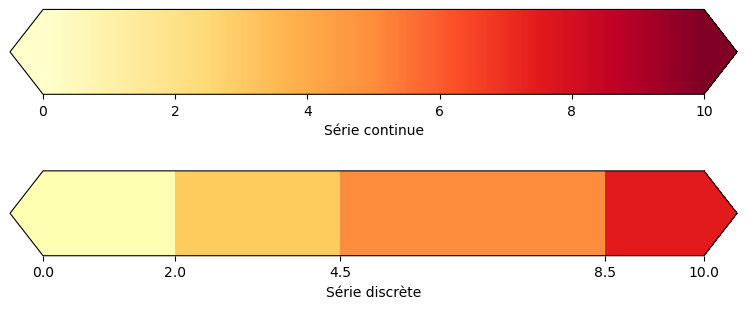

In [1230]:
# f = fig_discrete() # Pas le temps de régler le problème de centrage. Récupération de l'image png

img = """<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAusAAAE1CAYAAABeJa7/AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAA9J0lEQVR4nO3dd1xWdf/H8fclICAoggvMnDkyM0XMLeZMvS1vyZU5Mxta2nJkpk1HWfdd5krTyl+5wFGOHKnlyAxxlN6aidpQSVHciFzf3x8lSVwCItd1jvJ6Ph48gnO+43Muj5dvTuc6X4cxxggAAACA7eSzugAAAAAArhHWAQAAAJsirAMAAAA2RVgHAAAAbIqwDgAAANgUYR0AAACwKcI6AAAAYFPeVheQXU6nU7///rvVZQAAAOAGV6JECfn4+FhdRrbcEGHd6XTq3/++R4sXf211KQAAALjB3So/7UtOUv78+a0uJUs3RFh/443++uGHn5WY+JWCgwv9uTFt4VXn3w0z3SZJf31vXO2/ol3aflfbrhznyrGdGbdltd/ltsxqvIY+clGHW47hWl/TrPabK5pl9WeSzeO67tc8m8fozOL1My72O7OY+/L3Thf7XbW7chxnFvvTxs7iz8nVMWR37CvbZjm2qz7KuD+rbelqczF2Zttc9b2ircluPdLfb0PZndtV36zmyWpuZ1bbTPp92eqTybZ0Y2bex+RkHFd/Ti77XHs9WY1jnBnPgbRtV3vrzXafjK+LufK1cvlPW8ZxXPdxMbaLetKN5aoeF9vkar4sjsHI4bqPqz9u48jY7h/7MvbJuN/lXzGTsY7082Sc2+lqbFdz68o+Lo7B1TEq435XNaY7TV187+JfO5ftshrnWvq4OD1tP3eKnJquX9TIt4Q2mxOyO9vfs75ixQqNGfORoqPH/R3UAQAAgBzwUT51Uph26JQ+++wzq8vJkq3D+sGDB/Xgg530/vtDVKNGZavLAQAAwE0gRPnVQaHq9WA3/fDDD1aXkynbhvULFy7ogQfa6IEHmqlnz39ZXQ4AAABuIpUUqLoKVuSd4UpKSrK6nKuybVgfOPBBORzSf//7nNWlAAAA4CbUREUULB/VLVwq/WflbMSWYX3GjJGKiVmj+fPHydfX/p/SBQAAwI0nnxyKUpgO64Ja5itudTku2S6sx8XFacCAcfr009dUunSo1eUAAADgJlZAXuqkklqn4/rqq6+sLicDW4X1xMRERUW10/DhfdSiRV2rywEAAEAecIv8dK+Kq12zlvr111+tLicd24R1p9Op7t3vU7Vq5TV0aC+rywEAAEAeUktBqqwA1bu1oi5evGh1OWlsE9Zfe+0J7dlzUB9//Iry5bNNWQAAAMgj2qi4UmXU0Nc+96/bIhUvX75c48Z9rJiYN1W4cEGrywEAAEAe9OeCSSW1U6c1a9Ysq8uRZIOwfuDAAT34YGdNmjRU1atXtLocAAAA5GHB8lGUwtSnew/t2LHD6nKsDeuXFz7q2rWVundva2UpAAAAgCSpogLUQCG6564InTx50tJaLA3rTz7ZVd7eXnr77aetLAMAAABIp7FCFCIf1Q0uJafTaVkdloX16dNHaNGidZo/fywLHwEAAMBW8smhDgrTUSWrpVcJC+uwQGxsrJ566i3Nnv2GSpWy7uABAACAq7m8YNLXOq5Vq1ZZUoPHw/rx48cVFdVOI0b0VdOmtT09PQAAAJBtJeWn1iqu+1vcq19++cXj83s0rKempuqhh+5TzZqVNWRIT09ODQAAAORIuIJURYGqV7qSkpOTPTq3R8P6q68+rp9//lUzZ46Sw+Hw5NQAAABAjrVWMTll1NDPs7dweyysL126VOPH/5+io8cpKCjQU9MCAAAA181H+dRZJfWjTuvjjz/22LweCevx8fF66KGumjLlBd15522emBIAAADIVYX/WjCpb89e2r59u0fmdHtYP3/+vKKiWqtbt3v14IP3uns6AAAAwG1uU4AaKkT31KitEydOuH0+t4Z1Y4z69+8sPz9fjR/PwkcAAAC48TVSiIoqv+qG3Or2BZPcGtanTRuhJUs2aN68Mcqf38edUwEAAAAe8eeCSaH6QxfVwqu4m+dyky1btmjQoPGaM+cN3XKLew8CAAAA8CR/eamTwvSNErVixQq3zeOWsH7s2DE98MB9GjWqn5o0iXDHFAAAAIClwuSntiqu9q1a6+DBg26ZI9fDempqqrp1a6eIiNv13HPdc3t4AAAAwDZqKEhVVVD1y1bWhQsXcn38XA/ro0Y9qgMHfteMGSNZ+AgAAAA3vdYqJklq6B+a62Pnalj/4osv9J//fKaYmDdVqBALHwEAAODm56186qSS2q0zmjlzZq6OnWth/eeff1b37g/qgw+G6447KuTWsAAAAIDt/blgUqj69e6juLi4XBs3V8L6uXPnFBXVRj17/ktdurTKjSEBAACAG0oFBaiRQtQ0vE6uLZh03WHdGKMnnuiswEB/vfnmwNyoCQAAALghNVSIiiu/6uTSgknXHdanTh2u5cs3ae7cMfLx8b7uggAAAIAbVT459G+F6pguqnkuLJh0XWH9u+++0zPPvKO5c0erZMli110MAAAAcKPzl5c6q6TWK1HLly+/rrFyHNb/+OMPPfDAfXr11cfUuHH4dRUBAAAA3ExC5at/qYQ6tG6rAwcO5HicHIX11NRUPfjgv1SnTjU9/XS3HE8OAAAA3KzuUiFVU0HVL1clxwsm5Sisv/TSI/r11wR9+OFLLHwEAAAAXEUrFVM+OdTAv0SO+l9zWF+8eLHee2+uYmLeVMGCATmaFAAAAMgL/lwwKUz/01lNnz79mvtfU1jft2+fevTopunTR+j228td82QAAABAXhMkHz2gMD3e9xHFxsZeU99sh/XLCx89/PD96tix+TUXCQAAAORV5VVAkSqi5hF1lZiYmO1+2Qrrxhg9+ugDCgoK1JgxT+a4SAAAACCvaqBghcpXdYpkf8GkbIX16Ohoffnlt5ozZzQLHwEAAAA54JBD7RWq40pRO6+wbPXJVlgvVaqUzp49r0OHjlxXgQAAAEBedlqpOqtUPfHFh9lqn62wXrduXb322uN64IEh+uOPE9dVIAAAAJAXJcupOfpddytIbdu2zVafbH/AdNCg8apfv7q6dHlBly5dynGRAAAAQF5jZLRYR1RQ3lqTkpDtftkO6w6HQ9Onx+jw4WMaMWJyjooEAAAA8qJvdVK/6II2JxyQt3f2PwN6Tc9ZDwwMVEzMUr3//jwtWrT2WmsEAAAA8pyDOqevdEwrvl2vYsWKXVPfa17BtEqVKvrwwxHq2XOUfvrp0LV2BwAAAPKM07qkeTqsliqmOnXqXHP/aw7rkvTAA0PUt297dejwvM6ePZ+TIQAAAICbWqqM5umwyquAPnfm7KmKOQrrkjRmzAwVKRKkfv1elzEmp8MAAAAAN6WV+kPJStWms0fkcDhyNEaOw7q3t7dmz16iNWu+1/vvz83pMAAAAMBN5wed1jad0oZ9u1SgQIEcj5PjsC5JoaGhmjdvoYYMeU+bNu24nqEAAACAm0KCkrVYRzV38UJVqFDhusa6rrAuSQ0aNNDo0QP0wANDdPTo8esdDgAAALhhXVCq5uh31VFhtWvX7rrHu+6wLklPPjlOkZHhLJgEAACAPMvIaJGOKkg+WnMp+wsfZSZXwrrD4dDUqfOVkHBCw4dPzI0hAQAAgBvKJp3Qb7qgzX8clJeXV66MmSthXfp7waTJk6MVE/NVbg0LAAAA2N4BndMaHdfKzRtUtGjRXBs318K6JFWuXFkzZnys3r1f1p49B3JzaAAAAMCWTv218FErFdPdd9+dq2PnaliXpA4dOuixx6IUFTVYZ86cy+3hAQAAANu4JKN5+l0VFaDFOVz4KDO5HtYl6fXXp6t48RA98shrLJgEAACAm9ZK/aEUGW08l/OFjzLjlrDu7e2tzz77Ql9/Haf33pvjjikAAAAAS+3UKW3XKW34eZf8/f3dMoe3W0aVVKJECc2fv0jNmzdVrVpV1KBBDXdNBQAAAHjUUSXrcx1VzBefq3z58m6bxy1X1i+rV6+exo59Uh07DtWRI8fcORUAAADgEReUqrn6XXUVrLZt27p1LreGdUnq33+s7rknQp07v6CUFBZMAgAAwI3LyGihjqqwfPRVLi18lBm3h/XLCyYlJiZp2LAJ7p4OAAAAcJsNOqHDuqDNxw7l2sJHmXF7WJekgIAAxcQs07RpCzV//ipPTAkAAADkqv06p3U6rlVbNqlIkSIemdMjYV2SKlasqI8+mqU+fV7V7t3xnpoWAAAAuG5JStF8HdbED6YqIiLCY/N6LKxL0v3336/+/TsqKmqwTp8+68mpAQAAgBz5c+Gjw6qsAPXt29ejc3s0rEvSq69+oLCwonr44VdZMAkAAAC2t0J/6JKMNpzL/RVKs+LxsH55waRNm3bqP//51NPTAwAAANm2Q6e0Q6e0cf9uty18lBm3LYqUmeLFi2v+/EVq2rSJIiKqqlGjmlaUAQAAAFzVkb8WPlq0dInKlStnSQ0ev7J+WZ06dfTmmwPVqdNQHT7MgkkAAACwj/N/LXxUX8Fq3bq1ZXVYFtYl6fHHR6tFizrq1GkoCyYBAADAFpwyWqgjCpGPvkr9w9JaLA3rDodDkyfP06lTZzV48H+tLAUAAACQ9OfCR0eVrM3Hf1G+fJbGZWvDuiQVKFBA0dFLNWPG55o7d6XV5QAAACAP269z+lrHtTp2s0JCQqwux/qwLkm33XabPvnkUz388KvatWu/1eUAAAAgD7q88NHk6dMUHh5udTmSbBLWJaldu3Z66qnO6tDheZ06dcbqcgAAAJCHXJJTc3VYVRSgPn36WF1OGtuEdUl65ZUPdOutJdSnzyssmAQAAACPWa4/5JTRhvNHrS4lHVuFdS8vL3322RJ9992PGj9+ltXlAAAAIA/YplP6Uae16cAe+fn5WV1OOpYsipSZokWLav78xbrnnkjVrl1VkZG1rC4JAAAAN6kjStYSHdXny5epTJkyVpeTga2urF9299136+23n1anTsP0228JVpcDAACAm9B5pWqOfldDhahVq1ZWl+OSLcO6JPXr97pat66vTp2G6uLFFKvLAQAAwE3EKaMFOqKiyq9Vqfa9OGzbsO5wODRx4hydPXtBzz/PgkkAAADIPeuVqARd1OZE6xc+yox9K9PfCyZ9/PESffbZcqvLAQAAwE1gn87qGyXqq62bFRwcbHU5mbLdB0z/qUKFCvrkk0/VtWtn+fn5Kji44J870p7s6Py7cdrjHo2LbVdud7U/u9uuMs7l700WfdJtu6L2DO2cGTal6+Py0ZZXjmcyfmtc7Hc1tqu+Wc3tauyr7c+0/9/7TBb7Mz2udH1dvObpB3cxThb7TYZv/t6f7o/dxf4rObOY+3J/p4v9rs61q51/rvZfLtR5lT6ZndPXO3dWf8dc/tVwcc66OpfSHY+rcVzVmMm2K7a7Om2u/ued2Ziu2rkY+8r+WR23q9fP1dtNunYuxnb1+rn6K3a11zltzMzrMS7ruXIeF+eny3au5r72elzPnXFb+r/SGbdl+c+Cyz4ZX0tzxXFn+58pl32u2ObqbSSredL6uBjHuOibxX4jh8s+l6V/O3JkrCftv67Hcfl2k3EaOY2L/un6ODL0/Xvsq8ztcp6M7XI0j4s5XP01cPlXPpvbrtye3W12mftax7kkoxgd1tQZH6pmzZqyO4e5QR5oPnr0AL355icKDi4qh8ORdQfc1IwxOnHihIKDgzkfwPmADDgncCXOB1zJGKOU/b/rpwsn5evra3U5WbphwvqpU6cUFBSkpKQkFSpUyOpyYDHOB1yJ8wH/xDmBK3E+4Eo32vlg63vWAQAAgLyMsA4AAADYFGEdAAAAsKkbJqz7+vpq5MiRN8QHAeB+nA+4EucD/olzAlfifMCVbrTz4Yb5gCkAAACQ19wwV9YBAACAvIawDgAAANgUYR0AAACwKcI6AAAAYFOEdQAAAMCmboiwPnHiRJUrV05+fn6qVauWvvnmG6tLgkVGjx6t2rVrq2DBgipevLjat2+vPXv2WF0WbGL06NFyOBwaNGiQ1aXAIr/99pseeughFSlSRAUKFFCNGjUUGxtrdVmwwKVLl/Tiiy+qXLly8vf3V/ny5fXKK6/I6XRaXRo85Ouvv1a7du1UsmRJORwOLVy4MN1+Y4xGjRqlkiVLyt/fX02aNNGPP/5oTbGZsH1YnzNnjgYNGqThw4crLi5OjRo1UuvWrXXo0CGrS4MF1q1bp/79++vbb7/VypUrdenSJbVs2VJnz561ujRYbMuWLZo6daqqV69udSmwyIkTJ9SgQQP5+Pho2bJl2rVrl8aPH6/ChQtbXRosMHbsWE2ePFkTJkzQ7t27NW7cOL355pt67733rC4NHnL27FndddddmjBhgsv948aN09tvv60JEyZoy5YtCg0NVYsWLXT69GkPV5o52z9nvU6dOgoPD9ekSZPStt1+++1q3769Ro8ebWFlsIM//vhDxYsX17p169S4cWOry4FFzpw5o/DwcE2cOFGvvfaaatSoof/85z9WlwUPGzp0qDZs2MD/fYUk6V//+pdKlCih6dOnp22LiopSgQIF9Mknn1hYGazgcDi0YMECtW/fXtKfV9VLliypQYMGaciQIZKk5ORklShRQmPHjtWjjz5qYbXp2frK+sWLFxUbG6uWLVum296yZUtt3LjRoqpgJ0lJSZKkkJAQiyuBlfr376+2bduqefPmVpcCCy1evFgRERHq2LGjihcvrpo1a+qDDz6wuixYpGHDhlq9erX27t0rSdq+fbvWr1+vNm3aWFwZ7CA+Pl5HjhxJlzF9fX0VGRlpu4zpbXUBmTl27JhSU1NVokSJdNtLlCihI0eOWFQV7MIYo2eeeUYNGzZUtWrVrC4HFpk9e7a2bt2qLVu2WF0KLLZ//35NmjRJzzzzjF544QV99913euqpp+Tr66sePXpYXR48bMiQIUpKSlKVKlXk5eWl1NRUvf766+ratavVpcEGLudIVxnz4MGDVpR0VbYO65c5HI50PxtjMmxD3jNgwADt2LFD69evt7oUWOSXX37RwIEDtWLFCvn5+VldDizmdDoVERGhN954Q5JUs2ZN/fjjj5o0aRJhPQ+aM2eOZs2apU8//VR33HGHtm3bpkGDBqlkyZLq2bOn1eXBJm6EjGnrsF60aFF5eXlluIqekJCQ4Tch5C1PPvmkFi9erK+//lqlSpWyuhxYJDY2VgkJCapVq1battTUVH399deaMGGCkpOT5eXlZWGF8KSwsDBVrVo13bbbb79d0dHRFlUEKz3//PMaOnSounTpIkm68847dfDgQY0ePZqwDoWGhkr68wp7WFhY2nY7Zkxb37OeP39+1apVSytXrky3feXKlapfv75FVcFKxhgNGDBAMTEx+uqrr1SuXDmrS4KFmjVrpp07d2rbtm1pXxEREerWrZu2bdtGUM9jGjRokOFRrnv37lWZMmUsqghWOnfunPLlSx9zvLy8eHQjJEnlypVTaGhouox58eJFrVu3znYZ09ZX1iXpmWeeUffu3RUREaF69epp6tSpOnTokB577DGrS4MF+vfvr08//VSLFi1SwYIF0/6vS1BQkPz9/S2uDp5WsGDBDJ9XCAgIUJEiRfgcQx709NNPq379+nrjjTfUqVMnfffdd5o6daqmTp1qdWmwQLt27fT666+rdOnSuuOOOxQXF6e3335bffr0sbo0eMiZM2e0b9++tJ/j4+O1bds2hYSEqHTp0ho0aJDeeOMNVaxYURUrVtQbb7yhAgUK6MEHH7SwahfMDeD99983ZcqUMfnz5zfh4eFm3bp1VpcEi0hy+TVjxgyrS4NNREZGmoEDB1pdBizy+eefm2rVqhlfX19TpUoVM3XqVKtLgkVOnTplBg4caEqXLm38/PxM+fLlzfDhw01ycrLVpcFD1qxZ4zIz9OzZ0xhjjNPpNCNHjjShoaHG19fXNG7c2OzcudPaol2w/XPWAQAAgLzK1vesAwAAAHkZYR0AAACwKcI6AAAAYFOEdQAAAMCmCOsAAACATRHWAQAAAJsirAPAdTh58qRefvllHT582OpSAAA3IcI6AFyHXr166fz58woLC8uybZMmTTRo0CD3F+UGvXr1Uvv27a0uAwDyHBZFAoArJCQkaMSIEVq2bJmOHj2q4OBg3XXXXRo1apTq1auXru348eMVFxenTz75RA6HI8uxExMT5ePjo4IFC7qr/Ot24MABlStXTnFxcapRo0ba9qSkJBljVLhwYctqA4C8yNvqAgDATqKiopSSkqKPPvpI5cuX19GjR7V69WolJiZmaPvss89ma8yUlBT5+PgoJCQkt8v1mKCgIKtLAIA8idtgAOAvJ0+e1Pr16zV27Fjdc889KlOmjO6++24NGzZMbdu2TWuXlJSkfv36qXjx4ipUqJCaNm2q7du3p+0fNWqUatSooQ8//FDly5eXr6+vjDEZboO5ePGiBg8erFtuuUUBAQGqU6eO1q5dm2WN/fr1U4kSJeTn56dq1arpiy++SNsfHR2tO+64Q76+vipbtqzGjx+frn/ZsmX1xhtvqE+fPipYsKBKly6tqVOnpu0vV66cJKlmzZpyOBxq0qSJpIy3wTRp0kRPPfWUBg8erJCQEIWGhmrUqFFp+w8cOCCHw6Ft27alq93hcKQ7xl27dqlNmzYKDAxUiRIl1L17dx07dizT1wAA8hLCOgD8JTAwUIGBgVq4cKGSk5NdtjHGqG3btjpy5IiWLl2q2NhYhYeHq1mzZumuvu/bt09z585VdHR0usB6pd69e2vDhg2aPXu2duzYoY4dO+ree+/VTz/95LK90+lU69attXHjRs2aNUu7du3SmDFj5OXlJUmKjY1Vp06d1KVLF+3cuVOjRo3SiBEjNHPmzHTjjB8/XhEREYqLi9MTTzyhxx9/XP/73/8kSd99950kadWqVTp8+LBiYmKu+np99NFHCggI0ObNmzVu3Di98sorWrly5VXb/9Phw4cVGRmpGjVq6Pvvv9fy5ct19OhRderUKdtjAMBNzwAA0syfP98EBwcbPz8/U79+fTNs2DCzffv2tP2rV682hQoVMhcuXEjXr0KFCmbKlCnGGGNGjhxpfHx8TEJCQro2kZGRZuDAgcYYY/bt22ccDof57bff0rVp1qyZGTZsmMvavvzyS5MvXz6zZ88el/sffPBB06JFi3Tbnn/+eVO1atW0n8uUKWMeeuihtJ+dTqcpXry4mTRpkjHGmPj4eCPJxMXFpRunZ8+e5v777093LA0bNkzXpnbt2mbIkCFXHefEiRNGklmzZo0xxpgRI0aYli1bphvjl19+MZKueowAkNdwZR0ArhAVFaXff/9dixcvVqtWrbR27VqFh4enXZ2OjY3VmTNnVKRIkbQr8YGBgYqPj9fPP/+cNk6ZMmVUrFixq86zdetWGWNUqVKldOOsW7cu3ThX2rZtm0qVKqVKlSq53L979241aNAg3bYGDRrop59+Umpqatq26tWrp33vcDgUGhqqhISELF+bf7pyHEkKCwu7pnFiY2O1Zs2adMdfpUoVSbrqawAAeQ0fMAWAf/Dz81OLFi3UokULvfTSS+rbt69GjhypXr16yel0KiwszOW95Vc+KSUgICDTOZxOp7y8vBQbG5t2G8tlgYGBLvv4+/tnOqYxJsNTaYyLB375+Pik+9nhcMjpdGY6tiuZjZMvX74M86ekpKRr73Q61a5dO40dOzbD2Nl5FCYA5AWEdQDIQtWqVbVw4UJJUnh4uI4cOSJvb2+VLVs2x2PWrFlTqampSkhIUKNGjbLVp3r16vr111+1d+9el1fXq1atqvXr16fbtnHjRlWqVCnDLwRXkz9/fklKdyU+Jy7/X4XDhw+rZs2akpTh3v3w8HBFR0erbNmy8vbmnyMAcIXbYADgL8ePH1fTpk01a9Ys7dixQ/Hx8Zo3b57GjRun+++/X5LUvHlz1atXT+3bt9eXX36pAwcOaOPGjXrxxRf1/fffZ3uuSpUqqVu3burRo4diYmIUHx+vLVu2aOzYsVq6dKnLPpGRkWrcuLGioqK0cuVKxcfHa9myZVq+fLmkPx8luXr1ar366qvau3evPvroI02YMEHPPfdctusqXry4/P390z7smZSUlO2+V/L391fdunU1ZswY7dq1S19//bVefPHFdG369++vxMREde3aVd99953279+vFStWqE+fPtf9ywIA3CwI6wDwl8DAQNWpU0fvvPOOGjdurGrVqmnEiBF65JFHNGHCBEl/3uqxdOlSNW7cWH369FGlSpXUpUsXHThwQCVKlLim+WbMmKEePXro2WefVeXKlXXfffdp8+bNuvXWW6/aJzo6WrVr11bXrl1VtWpVDR48OC3YhoeHa+7cuZo9e7aqVauml156Sa+88op69eqV7Zq8vb317rvvasqUKSpZsmTaLyk58eGHHyolJUUREREaOHCgXnvttXT7S5YsqQ0bNig1NVWtWrVStWrVNHDgQAUFBaXdRgMAeR0rmAIAAAA2xaULAAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNEdYBAAAAmyKsAwAAADZFWAcAAABsirAOAAAA2BRhHQAAALApwjoAAABgU4R1AAAAwKYI6wAAAIBNeVtdQHYtWPCCZsxYLamE1aUAAADgBhb5zXo9eyLR6jKyxWGMMVYXkZWtW7eqUaP6GjbsAQUHB1pdDmzCHNpqdQlAej8dt7oCADZ28qsbIxze7C4Yo7dPn9IXq1apadOmVpeTJdtfWU9MTFRUVGsNH95RL7zQyepyYCMm9qzVJQDpmHUHrC4BgI39vvmi1SXgL0GOfOrUooW2HTyoUqVKWV1Opmx9z7rT6VT37q10551lNXToA1aXAwAAgJtA14AANffz0/3lK+jiRXv/EmXrsP7aa921Z8+v+vjjQcqXz9alAgAA4AbyalCwUmTULzjE6lIyZdsEvHz5co0bF6OYmGEqXJj71AEAAJB7/B0OTQ4uooXnz2nWrFlWl3NVtgzr8fHx6tatkyZPflzVq5ezuhwAAADchEp7e+u94BA92qOHduzYYXU5LtkurF+4cEEPPNBCXbo00kMP3WN1OQAAALiJ3ePnr8cCC+q+8HCdPHnS6nIysF1YHzDgPvn4eOnttx+2uhQAAADkAQMDC6q8t486hYXJ6XRaXU46tgrr06Y9qcWLv9P8+UPl6+tjdTkAAADIA/I5HPpvcIj+l5KiFwoHW11OOrYJ67GxsRo48APNnv2cSpUqanU5AAAAyEOC8+XTlOAievfMaa1atcrqctLYIqwfP35cUVFt9NJLXdS06V1WlwMAAIA86M78+fVqUGF1btVKhw4dsrocSTYI66mpqerWrYVq1iyvwYM7WF0OAAAA8rDOBQJ0r5+/7rvtNiUnJ1tdjvVh/ZVXHtL+/Uc1c+ZAORwOq8sBAABAHvdyUGE5JfUNKWJ1KdaG9SVLlujttxcpOnqogoICrCwFAAAAkCT5ORyaGlxEX5w/r48++sjSWiwL6/v379dDD3XWlClP6M47y1pVBgAAAJBBKW9vTQgO0RO9e2vbtm2W1WFJWD9//ryiopqre/d79OCDkVaUAAAAAGQq0s9PTwQW1P0RETpx4oQlNXg8rBtj9MQT7eTv76u33urt6ekBAACAbHsysKAqefuoY1hJSxZM8nhY/+CDAVq69HvNmzdE+fOz8BEAAADsK5/DoXeCQ/TTpRQNsWDBJI+G9S1btujpp6drzpzBuuUW6z9dCwAAAGSlcL58mhpSRBPPnNaKFSs8OrfHwvqxY8cUFdVGo0Z1VZMmd3pqWgAAAOC63eGTX68FFVbne1vr4MGDHpvXI2E9NTVVDz7YQrVrV9Rzz/3bE1MCAAAAuapjgQD9y99f91WsqAsXLnhkTo+E9VGjHtShQ39oxgwWPgIAAMCNa1RQYeWT1LdIUY/M5/aw/vnnn+s///lc0dHDVKhQAXdPBwAAALiNr8OhycFFtPTCec2YMcPt87k1rO/bt089enTVBx/01x13lHbnVAAAAIBH3OLtrfeDQ9T/4Ye1detWt87ltrB+7tw5RUW1UM+eTdWlS2N3TQMAAAB4XCNfPz0ZWFDt775biYmJbpvHLWHdGKPHH/+XChb015tvsvARAAAAbj79Awuqio+POpa8xW0LJrklrE+Z0l9ffhmnefOGyMfH2x1TAAAAAJbK53DoncIh+vlSiga7acGkXA/rmzdv1rPPfqi5cwcrLCwkt4cHAAAAbCMoXz59EFJEk86c1vLly3N9/FwN63/88YceeOBfevXVbmrcuFpuDg0AAADY0u0++TU6qLC6tmmr+Pj4XB0718J6amqqunZtobp1K+npp+/PrWEBAAAA2+tQIED3+fvr/sqVc3XBpFwL6yNGdNFvvx3Xhx8+xcJHAAAAyHNGBhWWjxzqXaRIro2ZK2F90aJFmjBhiWJihqlgQRY+AgAAQN6T3+HQ5JAQrbxwQdOmTcuVMa87rP/000/q2bObpk9/Urfffmtu1AQAAADckMK8/lww6al+/RQbG3vd411XWD979qyiolro4Yebq2PHhtddDAAAAHCja+Drp0GBBdW+Th0dP378usbKcVg3xujRR9uqcOEAjRnT87qKAAAAAG4mjwcW1B0+Poq65RalpqbmeJwch/WJEx/XV1/t1Ny5LHwEAAAAXMnhcOjtwiE6dClVz13Hgkk5CuubNm3S4MEzNXfuYIWGume1JgAAAOBGVihfPk0NKaIPzp7RkiVLcjTGNYf1hIQEdezYTq+//pAaNqyao0kBAACAvKCKj49GBwWrW7t22r9//zX3v6awfunSJXXp0lwNG1bVwIH3XfNkAAAAQF7z7wIF/lw0qXIVnT9//pr6XlNYf/HFLjp69KSmTRvAwkcAAABANr1YKEh+Dod6FikqY0y2+2U7rC9YsECTJi1TdPQwBQb656hIAAAAIC/K73BoUkgRrUm+oHHBIdnul62wvnfvXvXq9ZA+/PApValSKsdFAgAAAHlVmJeXJgaH6OVTSdqyZUu2+mQrrH/zzTcqWNBf994bfl0FAgAAAHlZRH5f3erlpfnNmmerfbbCes+ePXXbbWHq1+/9a7rHBgAAAMDf3jiVJC85NPLI4Wy1z1ZY9/b21uzZK7VmzU69/37OnhEJAAAA5GWfnz+neefO6vP/7VaBAgWy1SfbHzANDQ3VvHmLNWTIR9q4cXeOiwQAAADymr0pKRp88oQ+WbRIFSpUyHa/a3p0Y4MGDTR6dA917DhWR4+euOYiAQAAgLzmtNOpfieOq3dAoNq1a3dNfa95BdMnn5yiyMhq6tLlLV26lHqt3QEAAIA8wxij506eUEkvL71z8tovdl9zWHc4HPrgg6X6448kDR/+yTVPCAAAAOQVU8+e0faUi4r59Vd5eXldc/9rDuuSFBAQoJiYlZo8ebliYjbmZAgAAADgprYpOVnjT5/Sgk2bVLRo0RyNkaOwLkmVKlXSzJmz1Lv3u9qz59ecDgMAAADcdA6npuqJE8c1slCQateuneNxchzWJenf//63HnvsXnXoMFpnzpy/nqEAAACAm8JFY/RE4nHd4+unwScSr2us6wrrkvT663NUokRh9e07gQWTAAAAkOe9fipJ543RR8ePyeFwXNdY1x3W/1wwaZXWr9+ld9/9/HqHAwAAAG5YC8+dU/S5s1q853/y9/e/7vGuO6xLUvHixTVv3ud64YVPtGHDrtwYEgAAALih/C8lRUOTTuj/Pv9c5cuXz5UxcyWsS1K9evU0blwvdew4TkeOsGASAAAA8o5TTqceTTyuRwIC1bZt21wbN9fCuiQ98cQkNW16pzp3HqeUlEu5OTQAAABgS8YYPXsyUbd6e+mtHCx8lJlcDesOh0NTpizRiRNnNGzYx7k5NAAAAGBLk8+c0Q8pKYr+7bccLXyUmVwN69KfCyZFR6/UtGkrNW/e+tweHgAAALCNDckX9M6ZU1q4ebOKFCmS6+PneliXpIoVK+qjj/5PDz/8nnbv/sUdUwAAAACWOpx6Sf1PJOrdqVNVq1Ytt8zhlrAuSffff78GDGirqKgxOn36nLumAQAAADzuojF6LDFRLfz81LdvX7fN47awLkmvvjpbJUuG6OGH32PBJAAAANw0Xkk6qRQZzTh+3K3zuDWse3l56bPPVmrTpj36z38Wu3MqAAAAwCNizp3VwvPntGjPHvn5+bl1Lm+3ji6pWLFimj//CzVtGqlatSqoceNq7p4SAAAAcIvdKRc1LOmk5i9ZonLlyrl9PrdeWb+sTp06euut3urc+U0dPpzoiSkBAACAXJXkdKpfYqIeCyyo1q1be2ROj4R1SXrssYlq2bKGOnViwSQAAADcWJzG6JmTiSrv7a03c3nho8x4LKw7HA5NmvSFTp06p8GDZ3pqWgAAAOC6TTxzWrtTUjTv99+UL5/HIrTnwrokFShQQDExqzRz5mrNmfONJ6cGAAAAcuSb5At698xpLfzuO4WEhHh0bo+GdUmqUKGCPv74M/XtO0G7dh3y9PQAAABAtv2eekkDTiTq/enTFR4e7vH5PR7WJaldu3YaOLCdOnQYrVOnWDAJAAAA9pNsjB5NPK57/fzVu3dvS2qwJKxL0ssvf6rSpYupT593WTAJAAAAtvNy0kk5JU0/fsyyGiwL615eXvr005XasuUnjR+/0KoyAAAAgAzmnzurLy6c1+KffnL7wkeZcfuiSJkpWrSo5s9foiZNGiki4jY1aXKnleUAAAAA+jHlooYnndSC5ctVpkwZS2ux7Mr6ZbVr19Y77zyszp3H6bffjltdDgAAAPKwk06n+iUe1xOBBdWyZUury7E+rEvSI49MUJs2EerUaawuXkyxuhwAAADkQU5j9PSJRFXy9tFYDy58lBlbhHWHw6GJEz/XuXPJev75mVaXAwAAgDxowpnT2nspRXMP/+7RhY8yY48qJPn7+ys6epU++WSNPvtsndXlAAAAIA9Zd+GC3j9zWou+/17BwcFWl5PGNmFdksqXL69PPpmtfv0m6ocfDlpdDgAAAPKAXy9d0pMnEzVxxgzVqFHD6nLSsVVYl6S2bdvqmWfuV4cOo5WUdNbqcgAAAHATu2CMHj1xXG39/NWzZ0+ry8nAdmFdkl56aZbKly+h3r3/y4JJAAAAcJtRSSeVT9K0RHs+ldCWYd3Ly0v/938rtXXrfr35ZozV5QAAAOAmNOfcWS27cF6L9u2Tr6+v1eW4ZOmiSJkpUqSI5s9fosjIhoqIuE1Nm95ldUkAAAC4SfyQclEvJZ3UohUrVLp0aavLuSpbXlm/LCIiQv/97yPq0uUt/frrMavLAQAAwE3ghNOpRxOPa0BgQTVv3tzqcjJl67AuSX37vqf77rtbHTuyYBIAAACuj9MYDTqRqMo+Phptk4WPMuMwN8AnOC9cuKAGDarp+PHTCgiw5/1EsMCFU1ZXAKR3lgsKAK7u0vGLVpcA/fn0F4ekbceOqXDhwlaXkyXb3rN+JT8/Py1Zsl7PPfecunTpIh8fH6tLgsVSUlI0e/ZszgfYBuckgMzwHmEfKSkpWrt2rfz9/a0uJVtuiCvrknTq1CkFBQUpKSlJhQoVsrocWIzzAXbDOQkgM7xH2MeN9mdh+3vWAQAAgLyKsA4AAADYFGEdAAAAsKkbJqz7+vpq5MiRtl1dCp7F+QC74ZwEkBneI+zjRvuzuGE+YAoAAADkNTfMlXUAAAAgryGsAwAAADZFWAcAAABsirAOAAAA2JStwvrEiRNVrlw5+fn5qVatWvrmm28ybb9u3TrVqlVLfn5+Kl++vCZPnuyhSuFOo0ePVu3atVWwYEEVL15c7du31549e7Lsx/kATxk9erQcDocGDRp01TZr166Vw+HI8PW///3Pc4UC8IhLly7pxRdfVLly5eTv76/y5cvrlVdekdPpvGof3iNyx9dff6127dqpZMmScjgcWrhwYbr9xhiNGjVKJUuWlL+/v5o0aaIff/wxy3Gjo6NVtWpV+fr6qmrVqlqwYIGbjiBrtgnrc+bM0aBBgzR8+HDFxcWpUaNGat26tQ4dOuSyfXx8vNq0aaNGjRopLi5OL7zwgp566ilFR0d7uHLktnXr1ql///769ttvtXLlSl26dEktW7bU2bNnr9qH8wGesmXLFk2dOlXVq1fPVvs9e/bo8OHDaV8VK1Z0c4UAPG3s2LGaPHmyJkyYoN27d2vcuHF688039d5772XZl/eI63P27FndddddmjBhgsv948aN09tvv60JEyZoy5YtCg0NVYsWLXT69Omrjrlp0yZ17txZ3bt31/bt29W9e3d16tRJmzdvdtdhZM7YxN13320ee+yxdNuqVKlihg4d6rL94MGDTZUqVdJte/TRR03dunXdViOskZCQYCSZdevWXbUN5wM84fTp06ZixYpm5cqVJjIy0gwcOPCqbdesWWMkmRMnTnisPgDWaNu2renTp0+6bR06dDAPPfTQVfvwHpH7JJkFCxak/ex0Ok1oaKgZM2ZM2rYLFy6YoKAgM3ny5KuO06lTJ3Pvvfem29aqVSvTpUuXXK85O2xxZf3ixYuKjY1Vy5Yt021v2bKlNm7c6LLPpk2bMrRv1aqVvv/+e6WkpLitVnheUlKSJCkkJOSqbTgf4An9+/dX27Zt1bx582z3qVmzpsLCwtSsWTOtWbPGjdUBsErDhg21evVq7d27V5K0fft2rV+/Xm3atMmyL+8R7hMfH68jR46kywe+vr6KjIy8ar6Urp4pMuvjTt6WzPoPx44dU2pqqkqUKJFue4kSJXTkyBGXfY4cOeKy/aVLl3Ts2DGFhYW5rV54jjFGzzzzjBo2bKhq1apdtR3nA9xt9uzZ2rp1q7Zs2ZKt9mFhYZo6dapq1aql5ORkffLJJ2rWrJnWrl2rxo0bu7laAJ40ZMgQJSUlqUqVKvLy8lJqaqpef/11de3a9ap9eI9wv8sZ0lU+OHjwYKb9riWTupstwvplDocj3c/GmAzbsmrvajtuXAMGDNCOHTu0fv36LNtyPsBdfvnlFw0cOFArVqyQn59ftvpUrlxZlStXTvu5Xr16+uWXX/TWW2/xDzFwk5kzZ45mzZqlTz/9VHfccYe2bdumQYMGqWTJkurZs6fLPrxHeM615suc9nEXW9wGU7RoUXl5eWX4jSUhISHDbzaXhYaGumzv7e2tIkWKuK1WeM6TTz6pxYsXa82aNSpVqlSmbTkf4E6xsbFKSEhQrVq15O3tLW9vb61bt07vvvuuvL29lZqamq1x6tatq59++snN1QLwtOeff15Dhw5Vly5ddOedd6p79+56+umnNXr06Gsah/eI3BUaGipJ15QvL/e71j7uZIuwnj9/ftWqVUsrV65Mt33lypWqX7++yz716tXL0H7FihWKiIiQj4+P22qF+xljNGDAAMXExOirr75SuXLlsuzD+QB3atasmXbu3Klt27alfUVERKhbt27atm2bvLy8sjVOXFwct2QBN6Fz584pX770kcrLyyvTRze6wntE7ipXrpxCQ0PT5YOLFy9q3bp1V82X0tUzRWZ93MqSj7W6MHv2bOPj42OmT59udu3aZQYNGmQCAgLMgQMHjDHGDB061HTv3j2t/f79+02BAgXM008/bXbt2mWmT59ufHx8zPz58606BOSSxx9/3AQFBZm1a9eaw4cPp32dO3curQ3nA6z2z6fB/POcfOedd8yCBQvM3r17zQ8//GCGDh1qJJno6GgLqgXgTj179jS33HKL+eKLL0x8fLyJiYkxRYsWNYMHD05rw3uEe5w+fdrExcWZuLg4I8m8/fbbJi4uzhw8eNAYY8yYMWNMUFCQiYmJMTt37jRdu3Y1YWFh5tSpU2ljdO/ePd3TBzds2GC8vLzMmDFjzO7du82YMWOMt7e3+fbbbz1+fMYYY5uwbowx77//vilTpozJnz+/CQ8PT/eovp49e5rIyMh07deuXWtq1qxp8ufPb8qWLWsmTZrk4YrhDpJcfs2YMSOtDecDrPbPsP7Pc3Ls2LGmQoUKxs/PzwQHB5uGDRuaJUuWeL5QAG536tQpM3DgQFO6dGnj5+dnypcvb4YPH26Sk5PT2vAe4R6XH4H5z6+ePXsaY/58fOPIkSNNaGio8fX1NY0bNzY7d+5MN0ZkZGRa+8vmzZtnKleubHx8fEyVKlUs/SXKYcxfn8IDAAAAYCu2uGcdAAAAQEaEdQAAAMCmCOsAAACATRHWAQAAAJsirAMAAAA2RVgHAAAAbIqwDgAAANgUYR0AcsHJkyf18ssv6/Dhw1aX4jEpKSkaO3asdu3aZXUpAHDTIqwDQC7o1auXzp8/r7CwsCzbNmnSRIMGDcr1GhwOhxYuXChJOnDggBwOh7Zt25br81zm4+Oj2267TVFRUTp9+rTb5gGAvIywDgAuJCQk6NFHH1Xp0qXl6+ur0NBQtWrVSps2bcrQdvz48QoMDNTo0aOzNXZMTIxeffXV3C45nVtvvVWHDx9WtWrV3DpPVFSUHn/8cfXt2zfDvlGjRqlGjRpunR8AbnbeVhcAAHYUFRWllJQUffTRRypfvryOHj2q1atXKzExMUPbZ599NltjpqSkyMfHRyEhIbldbgZeXl4KDQ11y9iXj+Oyp556Sk899ZRb5gKAvI4r6wDwDydPntT69es1duxY3XPPPSpTpozuvvtuDRs2TG3btk1rl5SUpH79+ql48eIqVKiQmjZtqu3bt6ftv3xl+cMPP1T58uXl6+srY0yG22AuXryowYMH65ZbblFAQIDq1KmjtWvXZlrjTz/9pMaNG8vPz09Vq1bVypUr0+3/520wJ06cULdu3VSsWDH5+/urYsWKmjFjRlr7X3/9VV26dFFISIgCAgIUERGhzZs3Z3oc/zz+Jk2aKDY2VpI0c+ZMvfzyy9q+fbscDoccDodmzpyZrdcNAPA3rqwDwD8EBgYqMDBQCxcuVN26deXr65uhjTFGbdu2VUhIiJYuXaqgoCBNmTJFzZo10969e9Ounu/bt09z585VdHS0vLy8XM7Xu3dvHThwQLNnz1bJkiW1YMEC3Xvvvdq5c6cqVqyYob3T6VSHDh1UtGhRffvttzp16lSW98CPGDFCu3bt0rJly1S0aFHt27dP58+flySdOXNGkZGRuuWWW7R48WKFhoZq69atcjqdaf1dHUfbtm1VrFgxLVu2TIUKFdK0adPUvHlz7dmzR507d9YPP/yg5cuXa9WqVZKkoKCgbL9uAIC/GABABvPnzzfBwcHGz8/P1K9f3wwbNsxs3749bf/q1atNoUKFzIULF9L1q1ChgpkyZYoxxpiRI0caHx8fk5CQkK5NZGSkGThwoDHGmH379hmHw2F+++23dG2aNWtmhg0b5rK2L7/80nh5eZlffvklbduyZcuMJLNgwQJjjDHx8fFGkomLizPGGNOuXTvTu3dvl+NNmTLFFCxY0Bw/ftzlflfHsXr1alO4cGGTnJycrm2lSpXM+++/n9bvrrvuSrc/O68bAOBvXFkHABeioqLUtm1bffPNN9q0aZOWL1+ucePGadq0aerVq5diY2N15swZFSlSJF2/8+fP6+eff077uUyZMipWrNhV59m6dauMMapUqVK67cnJyRnGvmz37t0qXbq0SpUqlbatXr16mR7P448/rqioKG3dulUtW7ZU+/btVb9+fUnStm3bVLNmzUyvav/zOGJjY3Xy5EmX/9dh//79Vx0nu68bAOBPhHUAuAo/Pz+1aNFCLVq00EsvvaS+fftq5MiR6tWrl5xOp8LCwlzeW164cOG07wMCAjKdw+l0ysvLS7GxsRlukwkMDHTZxxiTYZvD4ch0ntatW+vgwYNasmSJVq1apWbNmql///5666235O/vn2lfKeNxOJ1OlS5dWgcPHsyy7z/7Zed1AwD8ibAOANlUtWrVtOeYh4eH68iRI/L29lbZsmVzPGbNmjWVmpqqhIQENWrUKNt1HDp0SL///rtKliwpSS4fKflPxYoVU69evdSrVy81atRIzz//vN566y1Vr15d06ZNU2JiYrbvGQ8PD9evv/6qvXv3Zvi/Apflz59fqampGfrlxusGAHkFT4MBgH84fvy4mjZtqlmzZmnHjh2Kj4/XvHnzNG7cON1///2SpObNm6tevXpq3769vvzySx04cEAbN27Uiy++qO+//z7bc1WqVEndunVTjx49FBMTo/j4eG3ZskVjx47V0qVLXfZp3ry5KleurB49emj79u365ptvNHz48Ezneemll7Ro0SLt27dPP/74o7744gvdfvvtkqSuXbsqNDRU7du314YNG7R//35FR0dn+gtA8+bNVb9+fXXo0EHLli1TfHy8Nm7cqMGDB6c9RaZs2bKKj4/Xtm3bdOzYMSUnJ+fa6wYAeQVhHQD+ITAwUHXq1NE777yjxo0bq1q1ahoxYoQeeeQRTZgwQdKft50sXbpUjRs3Vp8+fVSpUiV16dJFBw4cUIkSJa5pvhkzZqhHjx569tlnVblyZd13333avHmzbr31Vpft8+XLpwULFig5OVl33323+vbtq9dffz3TOfLnz69hw4apevXqaty4sby8vDR79uy0fStWrFDx4sXVpk0b3XnnnRozZsxVn15z5fE3bdpUffv2VeXKldWlS5d0V/ujoqJ077336p577lGxYsX02Wef5errBgB5gcO4uvkRAAAAgOW4sg4AAADYFGEdAAAAsCnCOgAAAGBThHUAAADApgjrAAAAgE0R1gEAAACbIqwDAAAANkVYBwAAAGyKsA4AAADYFGEdAAAAsCnCOgAAAGBT/w9z9CaoiPhm8AAAAABJRU5ErkJggg==">"""

content = f"""
<h2> <i class="fa-solid fa-chart-column" style="color: #94bc14"></i> La discrétisation </h2> 
<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>En cartographie et en statistique, il est parfois nécessaire de simplifier l'information à transmettre.</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Notamment lorsque la quantité d'information à représenter est très importante.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>La réduction de l'information au sein de classes est appelée la discrétisation.</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
      {img}
      </div>
      </div>
    </div>
  </div>
<blockquote class="fs-3" style="width: 1200px;">
Réduire l'information en transformant des données continues ou déjà discrètes en classes d'intervalles distinctes, couvrant l'ensemble de la série statistique initiale
</blockquote>
</div>

"""
HTML(content)

<hr>

<h2> <i class="fa-solid fa-circle-question" style="color: #94bc14"></i> Pourquoi discrétiser ? </h2>  

In [1231]:
selected_discret = "FisherJenks"
k = 5
selected_cmap = "Blues"
data_d = discretisation(
    data.query("CS1_6=='1'").sort_values("IND"), selected_discret, k, selected_cmap
)

In [1232]:
data_c = data.query("CS1_6=='1'").sort_values("IND").copy()

cmap = cm.get_cmap("Blues", len(data_c))
cols = []
for i in range(cmap.N):
    rgba = cmap(i)
    cols.append(colors.rgb2hex(rgba))

data_c["colors"] = cols
data_c["IND_CLASS"] = data_c["IND"]

In [1233]:
map_d = map_altair(
    fr=data_d,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Répartition des agriculteurs en 2018",
    legend_title="Part des agriculteurs sur l'ensemble des CSP(%)",
)

map_c = map_altair(
    fr=data_c,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title="Répartition des agriculteurs en 2018",
    legend_title="Part des agriculteurs sur l'ensemble des CSP(%)",
)

In [1234]:
alt.hconcat(map_c, map_d).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

alt.HConcatChart(...)

L'oeil humain n'est pas en mesure d'associer un chiffre précis à la variable visuelle valeur (à l'inverse de la taille+forme). Seule la notion d'ordre est "innée" avec le rapport de noir et blanc sur une surface donnée. 

Pour avoir associée à un niveau de gris un chiffre, il faut donc discrétiser

<hr>

<h2> <i class="fa-solid fa-sitemap" style="color: #94bc14"></i> Schéma de production cartographique </h2>  


In [1278]:
svg = """<svg xmlns="http://www.w3.org/2000/svg" width="1272.283" height="569.868"><defs><clipPath id="a" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="b" clipPathUnits="userSpaceOnUse"><path d="M0 0h1555v736H0Z" clip-rule="evenodd"/></clipPath><clipPath id="c" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="d" clipPathUnits="userSpaceOnUse"><path d="M36 328h210v72H36Z" clip-rule="evenodd"/></clipPath><clipPath id="e" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="f" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="g" clipPathUnits="userSpaceOnUse"><path d="M412 236h117v42H412Z" clip-rule="evenodd"/></clipPath><clipPath id="h" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="i" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="j" clipPathUnits="userSpaceOnUse"><path d="M554 508h162v42H554Z" clip-rule="evenodd"/></clipPath><clipPath id="k" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="l" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="m" clipPathUnits="userSpaceOnUse"><path d="M624 224h266v67H624Z" clip-rule="evenodd"/></clipPath><clipPath id="n" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="o" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="p" clipPathUnits="userSpaceOnUse"><path d="M1009 324h215v42h-215z" clip-rule="evenodd"/></clipPath><clipPath id="q" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="r" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="s" clipPathUnits="userSpaceOnUse"><path d="M1329 324h159v42h-159z" clip-rule="evenodd"/></clipPath><clipPath id="t" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="u" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="v" clipPathUnits="userSpaceOnUse"><path d="M34 463h215v114H34Z" clip-rule="evenodd"/></clipPath><clipPath id="w" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="x" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="y" clipPathUnits="userSpaceOnUse"><path d="M154.5 475h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="z" clipPathUnits="userSpaceOnUse"><path d="M149.5 475h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="A" clipPathUnits="userSpaceOnUse"><path d="M149.5 475h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="B" clipPathUnits="userSpaceOnUse"><path d="M149.5 475h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="C" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="D" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="E" clipPathUnits="userSpaceOnUse"><path d="M140.5 505h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="F" clipPathUnits="userSpaceOnUse"><path d="M135.5 505h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="G" clipPathUnits="userSpaceOnUse"><path d="M135.5 505h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="H" clipPathUnits="userSpaceOnUse"><path d="M135.5 505h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="I" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="J" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="K" clipPathUnits="userSpaceOnUse"><path d="M149.5 535h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="L" clipPathUnits="userSpaceOnUse"><path d="M144.5 535h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="M" clipPathUnits="userSpaceOnUse"><path d="M144.5 535h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="N" clipPathUnits="userSpaceOnUse"><path d="M144.5 535h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="O" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="P" clipPathUnits="userSpaceOnUse"><path d="M370 43h201v114H370Z" clip-rule="evenodd"/></clipPath><clipPath id="Q" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="R" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="S" clipPathUnits="userSpaceOnUse"><path d="M517.5 55h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5V60c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="T" clipPathUnits="userSpaceOnUse"><path d="M512.5 55h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="U" clipPathUnits="userSpaceOnUse"><path d="M512.5 55h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="V" clipPathUnits="userSpaceOnUse"><path d="M512.5 55h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="W" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="X" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="Y" clipPathUnits="userSpaceOnUse"><path d="M500.5 85h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5V90c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="Z" clipPathUnits="userSpaceOnUse"><path d="M495.5 85h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aa" clipPathUnits="userSpaceOnUse"><path d="M495.5 85h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ab" clipPathUnits="userSpaceOnUse"><path d="M495.5 85h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ac" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="ad" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="ae" clipPathUnits="userSpaceOnUse"><path d="M532.5 115h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="af" clipPathUnits="userSpaceOnUse"><path d="M527.5 115h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ag" clipPathUnits="userSpaceOnUse"><path d="M527.5 115h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ah" clipPathUnits="userSpaceOnUse"><path d="M527.5 115h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ai" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aj" clipPathUnits="userSpaceOnUse"><path d="M620 60h274v81H620Z" clip-rule="evenodd"/></clipPath><clipPath id="ak" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="al" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="am" clipPathUnits="userSpaceOnUse"><path d="M663.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="an" clipPathUnits="userSpaceOnUse"><path d="M658.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ao" clipPathUnits="userSpaceOnUse"><path d="M658.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ap" clipPathUnits="userSpaceOnUse"><path d="M658.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aq" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="ar" clipPathUnits="userSpaceOnUse"><path d="M700.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="as" clipPathUnits="userSpaceOnUse"><path d="M695.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="at" clipPathUnits="userSpaceOnUse"><path d="M695.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="au" clipPathUnits="userSpaceOnUse"><path d="M695.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="av" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aw" clipPathUnits="userSpaceOnUse"><path d="M737.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="ax" clipPathUnits="userSpaceOnUse"><path d="M732.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ay" clipPathUnits="userSpaceOnUse"><path d="M732.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="az" clipPathUnits="userSpaceOnUse"><path d="M732.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aA" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aB" clipPathUnits="userSpaceOnUse"><path d="M774.5 97.5h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="aC" clipPathUnits="userSpaceOnUse"><path d="M769.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aD" clipPathUnits="userSpaceOnUse"><path d="M769.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aE" clipPathUnits="userSpaceOnUse"><path d="M769.5 97.5h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aF" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aG" clipPathUnits="userSpaceOnUse"><path d="M532 608h207v86H532Z" clip-rule="evenodd"/></clipPath><clipPath id="aH" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aI" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aJ" clipPathUnits="userSpaceOnUse"><path d="M655 621h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="aK" clipPathUnits="userSpaceOnUse"><path d="M650 621h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aL" clipPathUnits="userSpaceOnUse"><path d="M650 621h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aM" clipPathUnits="userSpaceOnUse"><path d="M650 621h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aN" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aO" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aP" clipPathUnits="userSpaceOnUse"><path d="M690 651h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="aQ" clipPathUnits="userSpaceOnUse"><path d="M685 651h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aR" clipPathUnits="userSpaceOnUse"><path d="M685 651h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aS" clipPathUnits="userSpaceOnUse"><path d="M685 651h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aT" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aU" clipPathUnits="userSpaceOnUse"><path d="M946 430h341v137H946Z" clip-rule="evenodd"/></clipPath><clipPath id="aV" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aW" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="aX" clipPathUnits="userSpaceOnUse"><path d="M1195.5 468h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="aY" clipPathUnits="userSpaceOnUse"><path d="M1190.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="aZ" clipPathUnits="userSpaceOnUse"><path d="M1190.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="ba" clipPathUnits="userSpaceOnUse"><path d="M1190.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bb" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bc" clipPathUnits="userSpaceOnUse"><path d="M1232.5 468h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="bd" clipPathUnits="userSpaceOnUse"><path d="M1227.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="be" clipPathUnits="userSpaceOnUse"><path d="M1227.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bf" clipPathUnits="userSpaceOnUse"><path d="M1227.5 468h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bg" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bh" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bi" clipPathUnits="userSpaceOnUse"><path d="M1195.5 523h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="bj" clipPathUnits="userSpaceOnUse"><path d="M1190.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bk" clipPathUnits="userSpaceOnUse"><path d="M1190.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bl" clipPathUnits="userSpaceOnUse"><path d="M1190.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bm" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bn" clipPathUnits="userSpaceOnUse"><path d="M1232.5 523h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="bo" clipPathUnits="userSpaceOnUse"><path d="M1227.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bp" clipPathUnits="userSpaceOnUse"><path d="M1227.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bq" clipPathUnits="userSpaceOnUse"><path d="M1227.5 523h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="br" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bs" clipPathUnits="userSpaceOnUse"><path d="M1336 475h145v47h-145z" clip-rule="evenodd"/></clipPath><clipPath id="bt" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bu" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bv" clipPathUnits="userSpaceOnUse"><path d="M1405.5 483h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="bw" clipPathUnits="userSpaceOnUse"><path d="M1400.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bx" clipPathUnits="userSpaceOnUse"><path d="M1400.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="by" clipPathUnits="userSpaceOnUse"><path d="M1400.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bz" clipPathUnits="userSpaceOnUse"><path d="M0 0h1629v745H0Z" clip-rule="evenodd"/></clipPath><clipPath id="bA" clipPathUnits="userSpaceOnUse"><path d="M1442.5 483h19c2.76 0 5 2.24 5 5v19c0 2.76-2.24 5-5 5h-19c-2.76 0-5-2.24-5-5v-19c0-2.76 2.24-5 5-5z"/></clipPath><clipPath id="bB" clipPathUnits="userSpaceOnUse"><path d="M1437.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bC" clipPathUnits="userSpaceOnUse"><path d="M1437.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath><clipPath id="bD" clipPathUnits="userSpaceOnUse"><path d="M1437.5 483h29v29h-29z" clip-rule="evenodd"/></clipPath></defs><g clip-path="url(#a)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#b)"><path d="m247.715 357.373 9.745 6.43-9.745 6.429h9.745v-12.86z" style="fill:#ebd95f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><g style="fill:#94bc14;fill-opacity:1"><path d="M394.166 250.051h.42l9.29 6.22-9.29 6.22h-.42" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><path d="M82 0c75.46 0 26.4-77 99-77" style="fill:none;stroke:#94bc14;stroke-width:9.19;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(141.323 363.802) scale(1.39924)"/><g style="fill:#94bc14;fill-opacity:1"><path d="m531.143 250.147 8.963 5.914-8.963 5.914h8.963v-11.828z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><g style="fill:#94bc14;fill-opacity:1"><path d="M606.85 250.567h.42l8.508 5.704-8.508 5.704h-.42" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><g style="fill:#94bc14;fill-opacity:1"><path d="M49 0h49" style="fill:#94bc14;fill-opacity:1;stroke:#94bc14;stroke-width:8.4529;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(470.144 256.06) scale(1.39924)"/></g><g style="fill:#94bc14;fill-opacity:1"><path d="m892.858 250.616 8.252 5.445-8.252 5.444h8.252v-10.889z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><g style="fill:#94bc14;fill-opacity:1"><path d="M991.641 339.188h.42l7.797 5.235-7.797 5.234h-.42" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><path d="M102 0c51.24 0 14.1 63 66 63" style="fill:none;stroke:#94bc14;stroke-width:7.78214;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(756.989 256.06) scale(1.39924)"/><g style="fill:#94bc14;fill-opacity:1"><path d="m1227.924 339.195 7.605 5.018-7.605 5.017h7.605v-10.035z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><g style="fill:#94bc14;fill-opacity:1"><path d="M1310.668 339.615h.42l7.149 4.808-7.15 4.807h-.42" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><g style="fill:#94bc14;fill-opacity:1"><path d="M84 0h55" style="fill:#94bc14;fill-opacity:1;stroke:#94bc14;stroke-width:7.17175;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(1116.593 344.213) scale(1.39924)"/></g><path d="m247.715 357.373 9.745 6.43-9.745 6.429h9.745v-12.86zm289.173 165.53h.42l9.29 6.22-9.29 6.219h-.42" style="fill:#ebd95f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M82 0c150.14 0 65.1 118 201 118" style="fill:none;stroke:#94bc14;stroke-width:9.19;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(141.323 363.802) scale(1.39924)"/><path d="m718.641 522.999 8.964 5.914-8.964 5.913h8.964V523Z" style="fill:#ebd95f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><g style="fill:#94bc14;fill-opacity:1"><path d="M991.641 338.719h.42l8.508 5.704-8.508 5.704h-.42" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g><path d="M65 0c143.56 0 55.4-132 190-132" style="fill:none;stroke:#94bc14;stroke-width:8.4529;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(635.255 528.913) scale(1.39924)"/><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="m134.894 461.7 6.43-9.746 6.429 9.745v-44.866l-6.43-9.608-6.43 9.608z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="m463.715 158.164 6.43 9.745 6.429-9.745v9.745h-12.859z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="M463.785 218.211v.42l6.22 9.29 6.22-9.29v-.42z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="M0 48v37" style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-width:9.19;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(470.144 99.346) scale(1.39924)"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="m750.56 141.373 6.429 9.745 6.43-9.745v9.745h-12.86z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="M750.629 205.618v.42l6.22 9.29 6.22-9.29v-.42z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="M0 36v40" style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-width:9.19;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(756.989 99.346) scale(1.39924)"/></g><path d="m628.825 605.82 6.43-9.744 6.43 9.745v-39.269l-6.43-9.609-6.43 9.61z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/><g style="fill:#c8c4b7;fill-opacity:1"><path d="m1110.164 428.117 6.43-9.744 6.429 9.744v-46.265l-6.43-9.608-6.43 9.608z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="m1401.206 472.893 6.429-9.745 6.43 9.745v-9.745h-12.86z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="M1401.275 382.482v-.42l6.22-9.29 6.22 9.29v.42z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:#e3e2db;stroke-opacity:1"/></g><g style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-opacity:1"><path d="M0-24v-59" style="fill:#e3e2db;fill-opacity:1;stroke:#e3e2db;stroke-width:9.19;stroke-linecap:butt;stroke-linejoin:round;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(1407.635 498.13) scale(1.39924)"/></g></g></g><g clip-path="url(#c)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#d)"><path d="M37.154 364c0-19.882 16.118-36 36-36h135.692c19.882 0 36 16.118 36 36s-16.118 36-36 36H73.154c-19.882 0-36-16.118-36-36z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#e)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:24px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(92.5 358)"><tspan x="0 19.984375 33.328125 45.328125 57.328125 70.671875 84.015625" y="0">Message</tspan></text><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:24px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(61 386)"><tspan x="0 12 25.34375 33.328125 39.984375 53.328125 66.671875 74.65625 88 101.34375 114.6875 120.01562 133.35938 146.70312" y="0">cartographique</tspan></text></g><g clip-path="url(#f)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#g)"><path d="M412 257c0-11.539 9.354-20.893 20.893-20.893h75.214c11.539 0 20.893 9.354 20.893 20.893 0 11.539-9.354 20.893-20.893 20.893h-75.214C421.354 277.893 412 268.539 412 257Z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#h)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(428 264.5)"><tspan x="0 15.15625 26.828125 38.5 50.171875 61.84375 73.515625" y="0">Données</tspan></text></g><g clip-path="url(#i)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#j)"><path d="M554 529c0-11.57 9.379-20.948 20.948-20.948h120.104c11.57 0 20.948 9.379 20.948 20.948 0 11.57-9.379 20.948-20.948 20.948H574.948C563.378 549.948 554 540.57 554 529Z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#k)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(570 536.5)"><tspan x="0 12.8125 24.484375 36.15625 47.828125 53.65625 65.328125 77 82.828125 93.328125 105 111.98438 117.8125" y="0">Fond de carte</tspan></text></g><g clip-path="url(#l)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#m)"><path d="M624.396 257.5c0-18.502 14.998-33.5 33.5-33.5h198.208c18.502 0 33.5 14.998 33.5 33.5 0 18.502-14.998 33.5-33.5 33.5H657.896c-18.502 0-33.5-14.998-33.5-33.5z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#n)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(672 252)"><tspan x="0 12.8125 19.796875 31.46875 43.140625 53.640625 59.46875 71.140625 78.125 95.609375 107.28125 113.10938 117.76562 129.4375 141.10938 146.9375 158.60938" y="0">Transformation en</tspan></text><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(646.5 277)"><tspan x="0 4.65625 16.328125 28 39.671875 51.34375 63.015625 74.6875 80.515625 91.015625 102.6875 109.67188 115.5 127.17188 138.84375 145.82812 157.5 169.17188 180.84375 185.5 197.17188 208.84375" y="0">langage cartographique</tspan></text></g><g clip-path="url(#o)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#p)"><path d="M1009 345c0-11.566 9.376-20.942 20.942-20.942h173.116c11.566 0 20.942 9.376 20.942 20.942s-9.376 20.942-20.942 20.942h-173.116c-11.566 0-20.942-9.376-20.942-20.942Z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#q)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(1024.5 352.5)"><tspan x="0 15.15625 22.140625 33.8125 45.484375 51.3125 55.96875 67.640625 79.3125 85.140625 96.8125 108.48438 114.3125 118.96875 130.64062 136.46875 146.96875 158.64062 165.625 171.45312" y="0">Création de la carte</tspan></text></g><g clip-path="url(#r)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#s)"><path d="M1329 345c0-11.554 9.367-20.921 20.921-20.921h117.158c11.554 0 20.921 9.367 20.921 20.921 0 11.554-9.367 20.921-20.921 20.921h-117.158c-11.554 0-20.921-9.367-20.921-20.921Z" style="fill:#94bc14;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#t)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#454122;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(1345 352.5)"><tspan x="0 17.484375 22.140625 32.640625 44.3125 50.140625 61.8125 73.484375 79.3125 90.984375 102.65625 114.32812" y="0">Mise en page</tspan></text></g><g clip-path="url(#u)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#v)"><path d="M34.451 468.561A5.561 5.561 0 0 1 40.012 463h202.976a5.561 5.561 0 0 1 5.56 5.561v102.878a5.561 5.561 0 0 1-5.56 5.561H40.012a5.561 5.561 0 0 1-5.56-5.561z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#w)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 34.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(34.5 459)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(71.5 500)"><tspan x="0 16.328125 28 32.65625 44.328125 54.828125 60.65625 65.3125 71.140625" y="0">Objectif </tspan></text></g><g clip-path="url(#x)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#y)"><g clip-path="url(#z)"><g clip-path="url(#A)"><g clip-path="url(#B)"><path d="M175.278 475h-22.556a3.222 3.222 0 0 0-3.222 3.222v21.75h29v-21.75a3.222 3.222 0 0 0-3.222-3.222Z" style="fill:#ffcc4d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M175.37 490.093c1.278-.363 1.278-.924 0-1.288l-.45-.124-.448-.132v.004l-2.368-.717 1.871-1.558h-.011l.397-.26.4-.289c1.04-.824.812-1.358-.506-1.207l-.513.072-.509.073h-.002l-2.4.273 1.426-2.562.25-.45c.645-1.16.226-1.58-.934-.936l-.45.227-.447.225h-.002l-2.115 1.2.274-2.373v-.002l.064-.51.062-.513c.151-1.317-.396-1.543-1.221-.502l-.318.402-1.818 2.296-.66-2.321-.001-.004-.28-.987c-.364-1.278-.96-1.278-1.324 0l-.14.493-.14.494-.661 2.325-1.5-1.893v-.001l-.318-.402-.32-.404c-.824-1.039-1.373-.811-1.22.507l.059.51.059.51.279 2.4-2.56-1.426-.448-.25c-1.161-.646-1.582-.226-.936.935l.25.448 1.426 2.56-2.4-.28-.51-.058-.511-.06c-1.318-.152-1.545.397-.507 1.22l.404.32.402.319 1.893 1.5-2.323.662-.493.14-.493.14c-1.278.364-1.278.959 0 1.323l.987.28.003.002 2.32.66-2.296 1.819-.402.319c-1.04.824-.814 1.373.502 1.222l.514-.065.51-.065h.001l2.375-.274-1.2 2.116v.002l-.225.448-.239.449c-.644 1.16-.218 1.579.942.933l.451-.249 2.566-1.426-.272 2.4v.002l-.065.509-.062.512c-.152 1.318.396 1.545 1.22.505l.319-.403.318-.403 1.5-1.895.66 2.324v.001l.14.493.142.494c.364 1.278.89 1.278 1.254 0l.213-.987v-.003l.729-2.321 1.534 1.894.335.403.328.403c.823 1.039 1.378.813 1.225-.504l-.062-.513-.062-.51v-.002l-.274-2.374 2.114 1.2h.002l.449.225.45.238c1.16.647 1.58.22.934-.94l-.226-.452-.226-.449v-.002l-1.2-2.117 2.374.274h.002l.51.065.514.062c1.317.152 1.542-.397.503-1.22l-.403-.32-.403-.318-1.894-1.568 2.321-.729h.003l.986-.212z" style="fill:#f4900c;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M171.757 489.5a7.757 7.757 0 1 1-15.514 0 7.757 7.757 0 0 1 15.514 0z" style="fill:#ffe8b6;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M178.5 500.778v-3.818c-2.325-3.071-6.591-8.266-8.861-8.266-2.157 0-6.118 4.691-8.501 7.794V504h14.14a3.222 3.222 0 0 0 3.222-3.222z" style="fill:#5c913b;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M156.75 493.528c-1.812 0-4.896 3.31-7.25 6.208v1.042a3.222 3.222 0 0 0 3.222 3.222h14.5s-3.058-4.415-6.084-7.512c-1.634-1.671-3.259-2.96-4.388-2.96z" style="fill:#3e721d;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#C)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 64.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(34.5 459)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(71.5 530)"><tspan x="0 14 25.671875 37.34375 42 46.65625 57.15625" y="0">Public </tspan></text></g><g clip-path="url(#D)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#E)"><g clip-path="url(#F)"><g clip-path="url(#G)"><g clip-path="url(#H)"><path d="M161.052 505.243c-1.372-.444-4.6-.323-5.407.727-2.098.04-4.56 1.936-4.882 4.438-.32 2.477.392 3.626.645 5.488.287 2.109 1.473 2.784 2.42 3.067 1.365 1.802 2.815 1.724 5.25 1.724 2.451 0 4.235-.851 5.421-2.41v-10.994c-.865-.884-2.023-1.58-3.447-2.04z" style="fill:#ffac33;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M156.485 519.328h4.075v8.055h-4.075z" style="fill:#ffdc5d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M163.894 512.333c-.46-.637-1.049-1.15-2.34-1.332.484.222.948.989 1.009 1.413.06.423.12.766-.263.343-1.535-1.698-3.208-1.029-4.865-2.066-1.157-.724-1.51-1.525-1.51-1.525s-.141 1.07-1.896 2.16c-.51.315-1.116 1.018-1.453 2.057-.242.746-.167 1.412-.167 2.55 0 .922.218 1.8.595 2.592.981 2.06 3.08 3.52 5.518 3.52 2.084 0 3.922-1.075 5.026-2.671a6.108 6.108 0 0 0 .951-2.19v-3.333c-.116-.668-.31-1.11-.605-1.518z" style="fill:#ffdc5d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M161.24 519.328h-5.435s.679 1.358 2.717 1.358c2.038 0 2.717-1.358 2.717-1.358zm-2.038-1.698h-1.358a.34.34 0 0 1 0-.68h1.358a.34.34 0 0 1 0 .68z" style="fill:#c1694f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M155.806 515.253a.68.68 0 0 1-.68-.679v-.68a.68.68 0 0 1 1.359 0v.68a.68.68 0 0 1-.68.68zm5.433 0a.68.68 0 0 1-.679-.679v-.68a.68.68 0 0 1 1.358 0v.68a.679.679 0 0 1-.679.68z" style="fill:#662113;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M152.417 522.722h4.027s.16 3.845 1.992 3.845 2.104-3.845 2.104-3.845h3.96V534H150v-8.883c0-1.59.806-2.395 2.417-2.395z" style="fill:#fa743e;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M152.405 525.944h.829V534h-.829z" style="fill:#dd551f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M142.162 520.687c4.754 0 7.019-3.182 7.22-8.584.12-3.269-1.797-5.744-5.246-6.86-1.372-.444-4.6-.323-5.407.726-1.098.021-2.291.553-3.229 1.41v10.775c.441.438.955.672 1.413.808 1.365 1.802 2.815 1.725 5.249 1.725z" style="fill:#ffac33;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M139.445 519.328h4.075v8.055h-4.075z" style="fill:#ffdc5d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M146.854 512.333c-.46-.637-1.049-1.15-2.34-1.332.484.222.948.989 1.009 1.413.06.423.12.766-.263.343-1.535-1.698-3.208-1.029-4.865-2.066-1.156-.724-1.51-1.525-1.51-1.525s-.14 1.069-1.896 2.158c-.509.316-1.115 1.02-1.452 2.058-.018.054-.022.106-.037.16v3.63c.1.472.26.924.465 1.352.981 2.061 3.08 3.52 5.518 3.52 2.084 0 3.922-1.075 5.026-2.671a6.05 6.05 0 0 0 1.086-3.44c0-2.067-.215-2.873-.74-3.6z" style="fill:#ffdc5d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M144.2 519.328h-5.435s.679 1.358 2.717 1.358c2.038 0 2.717-1.358 2.717-1.358zm-2.038-1.698h-1.358a.34.34 0 0 1 0-.68h1.358a.34.34 0 0 1 0 .68z" style="fill:#c1694f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M138.766 515.253a.68.68 0 0 1-.68-.679v-.68a.68.68 0 0 1 1.359 0v.68a.68.68 0 0 1-.68.68zm5.433 0a.68.68 0 0 1-.679-.679v-.68a.68.68 0 0 1 1.358 0v.68a.679.679 0 0 1-.679.68z" style="fill:#662113;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M147.583 522.722h-4.027s-.16 3.845-1.992 3.845-2.12-3.845-2.12-3.845H135.5V534H150v-8.883c0-1.59-.806-2.395-2.417-2.395z" style="fill:#99aab5;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M146.767 525.944h.828V534h-.828z" style="fill:#66757f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M152.384 517.126c-1.18-.382-3.955-.278-4.65.624-1.803.035-3.92 1.665-4.197 3.816-.275 2.13.338 3.118.555 4.718.247 1.814 1.266 2.394 2.082 2.637 1.172 1.55 2.419 1.483 4.512 1.483 4.088 0 6.035-2.735 6.207-7.38.104-2.811-1.544-4.939-4.51-5.898z" style="fill:#ffac33;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M148.432 529.235h3.341V534h-3.341z" style="fill:#ffdc5d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M154.721 523.222c-.395-.548-.902-.989-2.012-1.145.417.19.815.85.868 1.214.052.364.104.659-.226.295-1.32-1.46-2.758-.885-4.182-1.776-.995-.623-1.299-1.312-1.299-1.312s-.122.92-1.63 1.856c-.438.272-.96.877-1.249 1.77-.208.641-.143 1.213-.143 2.191 0 2.855 2.353 5.255 5.255 5.255 2.903 0 5.256-2.421 5.256-5.255-.001-1.775-.187-2.469-.638-3.093z" style="fill:#ffdc5d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M152.438 529.235h-4.672s.584 1.168 2.336 1.168c1.752 0 2.336-1.168 2.336-1.168zm-1.752-1.167h-1.168a.292.292 0 1 1 0-.583h1.168a.292.292 0 1 1 0 .583z" style="fill:#c1694f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M147.657 526.56a.679.679 0 0 1-.68-.68v-.678a.68.68 0 1 1 1.359 0v.679a.68.68 0 0 1-.68.679zm4.833 0a.679.679 0 0 1-.68-.68v-.678a.68.68 0 1 1 1.36 0v.679a.68.68 0 0 1-.68.679z" style="fill:#662113;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M154.101 531.583h-2.328s-.568 2.417-1.67 2.417c-1.103 0-1.671-2.417-1.671-2.417h-1.58c-.297 0-.58.026-.85.071-1.564.263-2.66 1.237-3.029 2.346h14.204c-.418-1.29-1.74-2.417-3.076-2.417z" style="fill:#5c913b;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#I)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 94.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(34.5 459)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(71.5 560)"><tspan x="0 12.8125 24.484375 31.46875 48.953125 60.625 66.453125" y="0">Format </tspan></text></g><g clip-path="url(#J)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#K)"><g clip-path="url(#L)"><g clip-path="url(#M)"><g clip-path="url(#N)"><path d="M171.083 564h-23.36c3.221 0 2.416-7.25 2.416-7.25 0-1.78 1.443-12.083 3.222-12.083h16.917s3.222 0 3.222 3.222v13.694s0 2.417-2.417 2.417z" style="fill:#99aab5;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M168.667 561.583c0 2.417 2.416 2.417 2.416 2.417h-24.166s-2.417 0-2.417-3.222v-22.556a3.222 3.222 0 0 1 3.222-3.222h17.722a3.222 3.222 0 0 1 3.223 3.222z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M166.25 551.111c0 .446-.36.806-.806.806H159a.805.805 0 1 1 0-1.611h6.444c.446 0 .806.36.806.805zm0-3.222c0 .445-.36.805-.806.805H159a.805.805 0 1 1 0-1.61h6.444c.446 0 .806.36.806.805zm0-3.222c0 .445-.36.805-.806.805H159a.805.805 0 1 1 0-1.61h6.444c.446 0 .806.36.806.805zm0 9.666c0 .446-.36.806-.806.806h-17.722a.805.805 0 1 1 0-1.611h17.722c.446 0 .806.36.806.805zm0 3.223c0 .445-.36.805-.806.805h-17.722a.805.805 0 1 1 0-1.611h17.722c.446 0 .806.36.806.806zm0 3.222c0 .445-.36.805-.806.805h-17.722a.805.805 0 1 1 0-1.61h17.722c.446 0 .806.36.806.805zm-1.611-18.528s1.611 0 1.611-1.611v-1.611s0-1.611-1.611-1.611h-16.111s-1.611 0-1.611 1.61v1.612s0 1.611 1.61 1.611z" style="fill:#99aab5;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M154.972 551.917s1.611 0 1.611-1.611v-4.834s0-1.61-1.61-1.61h-6.445s-1.611 0-1.611 1.61v4.834s0 1.61 1.61 1.61z" style="fill:#55acee;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#O)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#P)"><path d="M370.402 48.561A5.561 5.561 0 0 1 375.963 43h189.074a5.561 5.561 0 0 1 5.56 5.561v102.878a5.561 5.561 0 0 1-5.56 5.561H375.963a5.561 5.561 0 0 1-5.56-5.561z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#Q)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 34.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(370.5 39)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(407.5 80)"><tspan x="0 15.15625 26.828125 37.328125 49 60.671875 72.34375 79.328125 91 97.984375" y="0">Récupérer </tspan></text></g><g clip-path="url(#R)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#S)"><g clip-path="url(#T)"><g clip-path="url(#U)"><g clip-path="url(#V)"><path d="M515.722 84s-3.222 0-3.222-3.222V58.222s0-3.222 3.222-3.222h20.945c.805 0 1.61.806 1.61.806l2.417 2.416s.806.806.806 1.611v20.945s0 3.222-3.222 3.222z" style="fill:#31373d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M516.528 70.306V69.5s0-1.611 1.61-1.611h16.918c1.61 0 1.61 1.611 1.61 1.611v.806z" style="fill:#55acee;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M516.528 80.795v-10.49h20.139v10.473s0 1.61-1.611 1.61h-16.917c-1.611 0-1.611-1.593-1.611-1.593zm4.028-23.378s0-.806.805-.806h14.5c.844 0 .806.806.806.806v8.055s0 .806-.806.806h-14.5s-.805 0-.805-.806zm9.666 8.055h4.028v-8.055h-4.028z" style="fill:#e1e8ed;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#W)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 64.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(370.5 39)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(407.5 110)"><tspan x="0 14 25.671875 37.34375 42 52.5 63 74.671875 81.65625" y="0">Analyser </tspan></text></g><g clip-path="url(#X)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#Y)"><g clip-path="url(#Z)"><g clip-path="url(#aa)"><g clip-path="url(#ab)"><path d="m517.563 104.85-2.279 2.279-3.987-3.988 2.278-2.278z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m523.44 108.45-4.737-4.736a1.61 1.61 0 0 0-2.278 0l-2.278 2.278a1.61 1.61 0 0 0 0 2.278l4.736 4.736a3.222 3.222 0 1 0 4.556-4.556z" style="fill:#66757f;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M517.32 96.011c0 6.006-4.87 10.875-10.876 10.875-6.006 0-10.875-4.869-10.875-10.875s4.87-10.875 10.875-10.875c6.006 0 10.875 4.869 10.875 10.875z" style="fill:#8899a6;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M514.097 96.011a7.653 7.653 0 1 1-15.306 0 7.653 7.653 0 0 1 15.306 0z" style="fill:#bbddf5;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#ac)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 94.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(370.5 39)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(407.5 140)"><tspan x="0 6.984375 22.140625 26.796875 37.296875 47.796875 54.78125 66.453125 72.28125 76.9375 87.4375 99.109375 106.09375 113.07812" y="0">(Discrétiser) </tspan></text></g><g clip-path="url(#ad)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#ae)"><g clip-path="url(#af)"><g clip-path="url(#ag)"><g clip-path="url(#ah)"><path d="M552.472 116.611h-20.944a2.417 2.417 0 0 0-2.417 2.417v20.944a2.417 2.417 0 0 0 2.417 2.417h20.944a2.417 2.417 0 0 0 2.417-2.417v-20.944a2.417 2.417 0 0 0-2.417-2.417z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M552.472 115.806h-20.944a3.222 3.222 0 0 0-3.222 3.222v20.944a3.222 3.222 0 0 0 3.222 3.222h20.944a3.222 3.222 0 0 0 3.222-3.222v-20.944a3.222 3.222 0 0 0-3.222-3.222zm0 1.61c.889 0 1.611.723 1.611 1.612v3.222h-4.833v-4.833zm-3.222 12.89h4.833v4.833h-4.833zm0-1.612v-4.833h4.833v4.833zm-1.611-11.277v4.833h-4.833v-4.833zm-4.833 6.444h4.833v4.833h-4.833zm0 6.445h4.833v4.833h-4.833zm-1.612-12.89v4.834h-4.833v-4.833zm-4.833 6.445h4.833v4.833h-4.833zm0 6.445h4.833v4.833h-4.833zm-6.444-11.278c0-.889.722-1.611 1.61-1.611h3.223v4.833h-4.833zm0 4.833h4.833v4.833h-4.833zm0 6.445h4.833v4.833h-4.833zm1.61 11.277a1.613 1.613 0 0 1-1.61-1.61v-3.223h4.833v4.833zm4.834 0v-4.833h4.833v4.833zm6.445 0v-4.833h4.833v4.833zm9.666 0h-3.222v-4.833h4.833v3.222c0 .889-.722 1.611-1.61 1.611z" style="fill:#e1e8ed;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M537.972 141.583h-4.833V127.89c0-.89.722-1.611 1.611-1.611h1.611c.89 0 1.611.722 1.611 1.61z" style="fill:#5c913b;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M550.861 141.583h-4.833V122.25c0-.89.722-1.611 1.61-1.611h1.612c.89 0 1.611.722 1.611 1.611z" style="fill:#3b94d9;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M544.417 141.583h-4.834v-8.055c0-.89.722-1.611 1.611-1.611h1.612c.889 0 1.61.721 1.61 1.61z" style="fill:#dd2e44;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#ai)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aj)"><path d="M620.138 65.586A5.586 5.586 0 0 1 625.724 60h262.552a5.586 5.586 0 0 1 5.586 5.586v69.828a5.586 5.586 0 0 1-5.586 5.586H625.724a5.586 5.586 0 0 1-5.586-5.586z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#ak)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 29.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(620.5 56.5)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(657.5 92.5)"><tspan x="0 14 25.671875 43.15625 47.8125 59.484375 64.140625 75.8125 87.484375 92.140625 103.8125 109.64062 121.3125 128.29688 139.96875 151.64062 163.3125 167.96875 179.64062 191.3125" y="0">Sémiologie graphique</tspan></text></g><g clip-path="url(#al)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#am)"><g clip-path="url(#an)"><g clip-path="url(#ao)"><g clip-path="url(#ap)"><path d="M687.5 112c0 8.008-6.492 14.5-14.5 14.5s-14.5-6.492-14.5-14.5 6.492-14.5 14.5-14.5 14.5 6.492 14.5 14.5z" style="fill:#dd2e44;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#aq)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#ar)"><g clip-path="url(#as)"><g clip-path="url(#at)"><g clip-path="url(#au)"><path d="M696.355 112.856c-.47-.47-.47-1.24 0-1.71l12.791-12.791c.47-.47 1.24-.47 1.71 0l12.79 12.791c.47.47.47 1.24 0 1.709l-12.79 12.79c-.47.47-1.24.47-1.71 0z" style="fill:#55acee;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#av)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aw)"><g clip-path="url(#ax)"><g clip-path="url(#ay)"><g clip-path="url(#az)"><path d="M733.355 112.856c-.47-.47-.47-1.24 0-1.71l12.791-12.791c.47-.47 1.24-.47 1.71 0l12.79 12.791c.47.47.47 1.24 0 1.709l-12.79 12.79c-.47.47-1.24.47-1.71 0z" style="fill:#ffac33;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#aA)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aB)"><g clip-path="url(#aC)"><g clip-path="url(#aD)"><g clip-path="url(#aE)"><path d="M775.708 112.57a.808.808 0 0 1 0-1.139l7.722-7.722a.808.808 0 0 1 1.139 0l7.723 7.723a.808.808 0 0 1 0 1.14l-7.723 7.72a.808.808 0 0 1-1.14 0l-7.72-7.722z" style="fill:#ffac33;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#aF)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aG)"><path d="M532.855 613.548a5.548 5.548 0 0 1 5.548-5.548h194.194a5.548 5.548 0 0 1 5.548 5.548v74.904a5.548 5.548 0 0 1-5.548 5.548H538.403a5.548 5.548 0 0 1-5.548-5.548z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#aH)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 34.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(533 605)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(570 646)"><tspan x="0 14 20.984375 32.65625 37.3125 48.984375 54.8125 66.484375 73.46875" y="0">Projeter </tspan></text></g><g clip-path="url(#aI)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aJ)"><g clip-path="url(#aK)"><g clip-path="url(#aL)"><g clip-path="url(#aM)"><path d="M664.5 621c-8.008 0-14.5 6.492-14.5 14.5s6.492 14.5 14.5 14.5 14.5-6.492 14.5-14.5-6.492-14.5-14.5-14.5zm-12.849 15.306h3.209c.074 2.018.42 3.923.99 5.638h-2.5a12.796 12.796 0 0 1-1.699-5.638zm13.655-8.862v-4.768c2.212.352 4.158 2.14 5.477 4.768zm6.163 1.612c.607 1.678.982 3.592 1.06 5.638h-7.223v-5.638zm-7.775-6.38v4.768h-5.477c1.318-2.629 3.265-4.416 5.477-4.768zm0 6.38v5.638h-7.224c.08-2.046.454-3.96 1.061-5.638zm-8.833 5.638h-3.21a12.81 12.81 0 0 1 1.698-5.638h2.5c-.568 1.715-.914 3.62-.988 5.638zm1.61 1.612h7.223v5.638h-6.163c-.607-1.678-.982-3.592-1.06-5.638zm7.223 7.25v4.768c-2.212-.352-4.159-2.14-5.477-4.768zm1.612 4.768v-4.768h5.477c-1.318 2.629-3.265 4.416-5.477 4.768zm0-6.38v-5.638h7.225c-.08 2.046-.454 3.96-1.061 5.638zm8.834-5.638h3.208a12.785 12.785 0 0 1-1.697 5.638h-2.5c.568-1.715.914-3.62.99-5.638zm0-1.612c-.075-2.017-.421-3.923-.99-5.638h2.5a12.788 12.788 0 0 1 1.698 5.638zm.413-7.25h-2.017a13.95 13.95 0 0 0-2.11-3.382 12.916 12.916 0 0 1 4.127 3.382zm-15.98-3.382a13.927 13.927 0 0 0-2.11 3.382h-2.016a12.927 12.927 0 0 1 4.127-3.382zm-4.126 19.494h2.017a13.88 13.88 0 0 0 2.11 3.381 12.914 12.914 0 0 1-4.127-3.381zm15.98 3.381a13.92 13.92 0 0 0 2.11-3.381h2.016a12.914 12.914 0 0 1-4.127 3.381z" style="fill:#3b88c3;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#aN)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 64.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(533 605)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(570 676)"><tspan x="0 16.328125 28 39.671875 51.34375 58.328125 70 74.65625 79.3125 89.8125 101.48438 108.46875" y="0">Généraliser </tspan></text></g><g clip-path="url(#aO)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aP)"><g clip-path="url(#aQ)"><g clip-path="url(#aR)"><g clip-path="url(#aS)"><path d="m713.28 677.722-26.002-26.002c-1.253-1.253-2.278-.829-2.278.943v24.115a3.232 3.232 0 0 0 3.222 3.222h24.115c1.772 0 2.196-1.025.943-2.278zm-14.612-4.166h-5.612a1.616 1.616 0 0 1-1.612-1.612v-5.613c0-.886.514-1.098 1.14-.472l6.556 6.557c.626.626.413 1.14-.472 1.14z" style="fill:#ffcc4d;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#aT)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aU)"><path d="M946 435.61a5.59 5.59 0 0 1 5.59-5.59h329.82a5.59 5.59 0 0 1 5.59 5.59v125.78a5.59 5.59 0 0 1-5.59 5.59H951.59a5.59 5.59 0 0 1-5.59-5.59Z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#aV)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 29.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(946.5 427)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(983.5 463)"><tspan x="0 15.15625 26.828125 33.8125 39.640625 51.3125 62.984375 69.96875 81.640625 93.3125 104.98438 109.64062 121.3125 127.14062 141.14062 151.64062 162.14062 166.79688 177.29688 183.125 194.79688" y="0">Cartographie Assisté </tspan></text><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(983.5 493)"><tspan x="0 11.671875 23.34375 30.328125 36.15625 52.484375 59.46875 71.140625 75.796875 87.46875 99.140625 104.96875 116.64062 128.3125 135.29688 141.125 148.10938 163.26562 177.26562 193.59375 200.57812" y="0">par Ordinateur (CAO) </tspan></text></g><g clip-path="url(#aW)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#aX)"><g clip-path="url(#aY)"><g clip-path="url(#aZ)"><g clip-path="url(#ba)"><path d="M1219.5 493.778s0 3.222-3.222 3.222h-22.556s-3.222 0-3.222-3.222v-22.556c0-3.222 3.222-3.222 3.222-3.222h22.556c3.222 0 3.222 3.222 3.222 3.222z" style="fill:#88c9f9;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1209.833 469.611c.806 0 1.611 2.417 2.417 2.417.806 0 2.417 0 2.417.805 0 .806-2.417.806-2.417 1.611 0 .806-.806.806-1.611.806-.806 0-2.417 0-2.417-.806 0-.805 1.611 0 1.611-.805 0-.806-.805-4.028 0-4.028zm-2.416 6.445c0-.806 1.61-.806 1.61-.806s.806 1.611 0 1.611c-.805 0-1.61-.805-1.61-.805zm1.61 1.61c-.805 0-.805 1.612-.805 2.417 0 .806 0 2.417-.805 2.417-.806 0-1.611.806-1.611 1.611 0 .806-.806 1.611-1.612 1.611-.805 0-1.61 1.611-1.61 1.611s-3.223.806-4.028.806c-.806 0-2.417 0-2.417.805 0 .806-2.417 1.612-.806 1.612 1.611 0 1.611-.806 2.417-.806h1.611s2.417-.806 2.417 0 0 1.611.805 1.611c.806 0 1.611-.805 1.611-1.611 0-.806.806-.806 1.612-.806.805 0 1.61 0 1.61-.805 0-.806.806-1.611 1.612-1.611.805 0 .805-1.611.805-2.417 0-.805 0-2.417.806-2.417.805 0 1.611-2.416.805-2.416-.805 0-1.61 0-1.61-.806 0-.805-.806-.805-.806-.805z" style="fill:#3e721d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1196.944 492.167c0-.806 0-1.611.806-1.611h2.417c.805 0 .805 0 0 .805-.806.806-.806 0-1.611 0-.806 0 0 1.611-.806 1.611s-.806-.805-.806-.805zm-3.222 2.416c0-.805.806-.805.806-1.61 0-.806-.806 0-.806-.806s.806-.806 1.611-.806c.806 0 .806.806.806 1.611 0 .806-.806.806-.806 1.611 0 .806-.805.806-.805.806s-.806 0-.806-.806z" style="fill:#3e721d;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#bb)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#bc)"><g clip-path="url(#bd)"><g clip-path="url(#be)"><g clip-path="url(#bf)"><path d="M1254.889 491.438c-.336-.775-.722-1.617-1.611-1.617h-.806c.89 0 1.611-.724 1.611-1.618v-13.752c0-.893-.721-1.618-1.61-1.618h-20.945c-.89 0-1.611.725-1.611 1.618v13.752c0 .894.721 1.618 1.61 1.618h-.805c-.89 0-1.343.809-1.61 1.617l-1.612 3.944c0 .894.722 1.618 1.611 1.618h25.778c.89 0 1.611-.724 1.611-1.618z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1227.506 495.45v.045l.137.558a1.61 1.61 0 0 0 1.463.947h25.778c.867 0 1.568-.689 1.605-1.55h-28.987z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1252.472 487.394c0 .447-.36.809-.805.809h-19.334a.807.807 0 0 1-.805-.81V475.26c0-.447.36-.808.805-.808h19.334c.445 0 .805.362.805.808z" style="fill:#5dadec;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1254.008 493.006-.613-1.752c-.192-.37-.511-.674-.957-.674h-20.822c-.444 0-.73.328-.93.834l-.555 1.593c-.177.48.36.809.805.809h6.105s.755-.038.888-.49c.155-.522.335-1.308.373-1.447.06-.213.313-.428.69-.428h6.91c.403 0 .601.204.653.456.034.165.252.92.353 1.436.09.46.984.472.984.472h5.312c.443 0 .98-.38.804-.809z" style="fill:#aebbc1;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1245.524 494.674h-6.268c-.302 0-.433-.276-.39-.543.043-.267.29-1.445.309-1.582.019-.137.22-.302.422-.302h5.651c.24 0 .395.132.443.394.047.264.243 1.322.259 1.564.015.242-.136.47-.426.47z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#bg)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><path d="M24 84.5a3.5 3.5 0 1 1-7 0 3.5 3.5 0 0 1 7 0z" style="fill:#492928;fill-opacity:1;fill-rule:evenodd;stroke:#492928;stroke-width:1;stroke-linecap:square;stroke-linejoin:bevel;stroke-miterlimit:10;stroke-dasharray:none;stroke-opacity:1" transform="translate(946.5 427)"/><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(983.5 518)"><tspan x="0 15.15625 26.828125 37.328125 47.828125 52.484375 64.15625 69.984375 83.984375 94.484375 104.98438 109.64062 120.14062 125.96875" y="0">Dessin Assisté</tspan></text><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(983.5 548)"><tspan x="0 11.671875 23.34375 30.328125 36.15625 52.484375 59.46875 71.140625 75.796875 87.46875 99.140625 104.96875 116.64062 128.3125 135.29688 141.125 148.10938 163.26562 177.26562 193.59375 200.57812" y="0">par Ordinateur (DAO) </tspan></text></g><g clip-path="url(#bh)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#bi)"><g clip-path="url(#bj)"><g clip-path="url(#bk)"><g clip-path="url(#bl)"><path d="M1218.873 550.065c-.52-1.692-1.373-4.88-1.873-6.095-.403-.98-.78-1.964-1.243-2.428-.464-.463-1.251-.427-1.727.047 0 0-1.989 1.35-2.702 2.242-.892.71-2.243 2.704-2.243 2.704-.475.475-.512 1.262-.048 1.726.464.464 1.448.84 2.429 1.244 1.213.5 4.402 1.35 6.095 1.873.289.089 1.401-1.024 1.313-1.313z" style="fill:#d99e82;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1201.49 527.276c.927.927.927 2.43 0 3.357l-3.357 3.357a2.375 2.375 0 0 1-3.356 0l-3.358-3.357a2.375 2.375 0 0 1 0-3.357l3.357-3.357a2.373 2.373 0 0 1 3.357 0z" style="fill:#ea596e;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1215.757 541.542-3.36 3.36-3.353 3.355-12.59-12.589 6.715-6.713z" style="fill:#ffcc4d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1216.34 551.004s2.183 1.199 2.773.61c.59-.59-.617-2.768-.617-2.768s-2.067.039-2.155 2.158z" style="fill:#292f33;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1192.258 531.472 6.715-6.714 4.195 4.196-6.713 6.714z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1193.098 532.31 6.713-6.713.84.84-6.714 6.713zm1.678 1.681 6.714-6.714.84.84-6.715 6.713z" style="fill:#99aab5;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#bm)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#bn)"><g clip-path="url(#bo)"><g clip-path="url(#bp)"><g clip-path="url(#bq)"><path d="M1254.889 546.438c-.336-.775-.722-1.617-1.611-1.617h-.806c.89 0 1.611-.724 1.611-1.618v-13.752c0-.893-.721-1.618-1.61-1.618h-20.945c-.89 0-1.611.725-1.611 1.618v13.752c0 .894.721 1.618 1.61 1.618h-.805c-.89 0-1.343.809-1.61 1.617l-1.612 3.944c0 .894.722 1.618 1.611 1.618h25.778c.89 0 1.611-.724 1.611-1.618z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1227.506 550.45v.045l.137.558a1.61 1.61 0 0 0 1.463.947h25.778c.867 0 1.568-.689 1.605-1.55h-28.987z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1252.472 542.394c0 .447-.36.809-.805.809h-19.334a.807.807 0 0 1-.805-.81V530.26c0-.447.36-.808.805-.808h19.334c.445 0 .805.362.805.808z" style="fill:#5dadec;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1254.008 548.006-.613-1.752c-.192-.37-.511-.674-.957-.674h-20.822c-.444 0-.73.328-.93.834l-.555 1.593c-.177.48.36.809.805.809h6.105s.755-.038.888-.49c.155-.522.335-1.308.373-1.447.06-.213.313-.428.69-.428h6.91c.403 0 .601.204.653.456.034.165.252.92.353 1.436.09.46.984.472.984.472h5.312c.443 0 .98-.38.804-.809z" style="fill:#aebbc1;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1245.524 549.674h-6.268c-.302 0-.433-.276-.39-.543.043-.267.29-1.445.309-1.582.019-.137.22-.302.422-.302h5.651c.24 0 .395.132.443.394.047.264.243 1.322.259 1.564.015.242-.136.47-.426.47z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#br)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#bs)"><path d="M1336.618 480.53a5.53 5.53 0 0 1 5.53-5.53h132.705a5.53 5.53 0 0 1 5.53 5.53v35.94a5.53 5.53 0 0 1-5.53 5.53h-132.706a5.53 5.53 0 0 1-5.53-5.53z" style="fill:#e3e2db;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g><g clip-path="url(#bt)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><text xml:space="preserve" style="font-variant:normal;font-weight:400;font-size:21px;font-family:&quot;Liberation Sans&quot;;-inkscape-font-specification:LiberationSans;writing-mode:lr-tb;fill:#492928;fill-opacity:1;fill-rule:nonzero;stroke:none" transform="translate(1348.5 508)"><tspan x="0 15.15625 29.15625 45.484375" y="0">DAO </tspan></text></g><g clip-path="url(#bu)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#bv)"><g clip-path="url(#bw)"><g clip-path="url(#bx)"><g clip-path="url(#by)"><path d="M1428.873 510.065c-.52-1.692-1.373-4.88-1.873-6.095-.403-.98-.78-1.964-1.243-2.428-.464-.463-1.251-.427-1.727.047 0 0-1.989 1.35-2.702 2.242-.892.71-2.243 2.704-2.243 2.704-.475.475-.512 1.262-.048 1.726.464.464 1.448.84 2.429 1.244 1.213.5 4.402 1.35 6.095 1.873.289.089 1.401-1.024 1.313-1.313z" style="fill:#d99e82;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1411.49 487.276c.927.927.927 2.43 0 3.357l-3.357 3.357a2.375 2.375 0 0 1-3.356 0l-3.358-3.357a2.375 2.375 0 0 1 0-3.357l3.357-3.357a2.373 2.373 0 0 1 3.357 0z" style="fill:#ea596e;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1425.757 501.542-3.36 3.36-3.353 3.355-12.59-12.589 6.715-6.713z" style="fill:#ffcc4d;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1426.34 511.004s2.183 1.199 2.773.61c.59-.59-.617-2.768-.617-2.768s-2.067.039-2.155 2.158z" style="fill:#292f33;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1402.258 491.472 6.715-6.714 4.195 4.196-6.713 6.714z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1403.098 492.31 6.713-6.713.84.84-6.714 6.713zm1.678 1.681 6.714-6.714.84.84-6.715 6.713z" style="fill:#99aab5;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g><g clip-path="url(#bz)" transform="matrix(.87526 .0002 -.0002 .87526 -30.041 -37.711)"><g clip-path="url(#bA)"><g clip-path="url(#bB)"><g clip-path="url(#bC)"><g clip-path="url(#bD)"><path d="M1464.889 506.438c-.336-.775-.722-1.617-1.611-1.617h-.806c.89 0 1.611-.724 1.611-1.618v-13.752c0-.893-.721-1.618-1.61-1.618h-20.945c-.89 0-1.611.725-1.611 1.618v13.752c0 .894.721 1.618 1.61 1.618h-.805c-.89 0-1.343.809-1.61 1.617l-1.612 3.944c0 .894.722 1.618 1.611 1.618h25.778c.89 0 1.611-.724 1.611-1.618z" style="fill:#ccd6dd;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1437.506 510.45v.045l.137.558a1.61 1.61 0 0 0 1.463.947h25.778c.867 0 1.568-.689 1.605-1.55h-28.987z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1462.472 502.394c0 .447-.36.809-.805.809h-19.334a.807.807 0 0 1-.805-.81V490.26c0-.447.36-.808.805-.808h19.334c.445 0 .805.362.805.808z" style="fill:#5dadec;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="m1464.008 508.006-.613-1.752c-.192-.37-.511-.674-.957-.674h-20.822c-.444 0-.73.328-.93.834l-.555 1.593c-.177.48.36.809.805.809h6.105s.755-.038.888-.49c.155-.522.335-1.308.373-1.447.06-.213.313-.428.69-.428h6.91c.403 0 .601.204.653.456.034.165.252.92.353 1.436.09.46.984.472.984.472h5.312c.443 0 .98-.38.804-.809z" style="fill:#aebbc1;fill-opacity:1;fill-rule:nonzero;stroke:none"/><path d="M1455.524 509.674h-6.268c-.302 0-.433-.276-.39-.543.043-.267.29-1.445.309-1.582.019-.137.22-.302.422-.302h5.651c.24 0 .395.132.443.394.047.264.243 1.322.259 1.564.015.242-.136.47-.426.47z" style="fill:#9aaab4;fill-opacity:1;fill-rule:nonzero;stroke:none"/></g></g></g></g></g></svg>"""
center_begin = """<div class="container"> <div class="row" > <div class="text-center"> """
center_end = """</div> </div> </div>"""
data =f"""
{center_begin}
{svg}
{center_end}"""
HTML(data)

<hr>

<h2> <i class="fa-solid fa-person-circle-question" style="color: #94bc14"></i> En amont de la discrétisation </h2>  

Le rôle du cartographe est de déterminer en amont de la production cartographique la <b>"meilleur" discrétisation</b>. Pour cela, il faut : 
<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Se poser les questions : </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>faut-il mettre en avant la répartition spatiale la plus conforme à la répartition statistique ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Ma carte sera-t-elle <b>comparée</b> à une autre ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dans le temps ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Avec des données de même nature ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Est-ce que mon <b>public</b> à besoin d'une discrétisation "simple", quitte à perdre une partie de l'information statistique.</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Analyser la distribution statistique</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>En la résumant par les valeurs centrales.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Puis par les paramètres de dispersion.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>En fonction des interprétations, la méthode de discrétisation peut-être <b>choisie et justifiée</b>.</p>
        </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h1> Analyse univariée</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-magnifying-glass-chart fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>


<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Visualiser la série statistique à l'aide de graphiques </h2>  

In [1235]:
source = csp_fr.query("CS1_6=='6'")
cs6_base = alt.Chart(
    source, title="Histogramme et kernel density", width=565, height=250
)

cs6_bar_15 = cs6_base.mark_bar(color="#54a24b",).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        bin=alt.Bin(maxbins=15),
        scale=alt.Scale(domain=(0, 40)),
        title="Part des ouvriers dans les emplois de chaque départements (%)",
    ),
    y=alt.Y(
        "count()",
        title="Nombre de départements",
        scale=alt.Scale(domain=(0, 40)),
    ),
    tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
)

cs6_bar_10 = cs6_base.mark_bar(color="#54a24b",).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        bin=alt.Bin(maxbins=10),
        scale=alt.Scale(domain=(0, 40)),
        title="Part des ouvriers dans les emplois de chaque départements (%)",
    ),
    y=alt.Y(
        "count()",
        title="Nombre de départements",
        scale=alt.Scale(domain=(0, 40)),
    ),
    tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
)

cs6_kd = (
    cs6_base.transform_density(
        "OBS_VALUE_p",
        as_=["OBS_VALUE_p", "value"],
        counts=True,
    )
    .mark_area(opacity=0.5, color="#e45756")
    .encode(
        x="OBS_VALUE_p:Q",
        y="value:Q",
    )
)


csall_base = alt.Chart(csp_fr, title="Boxplot", width=565, height=500)
cs6_box = csall_base.mark_boxplot(size=50).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        scale=alt.Scale(domain=(0, 45)),
        title="Part de chaque CSP dans les emplois des départements (%)",
    ),
    y=alt.Y("CS1_6:N", title="CSP"),
    color=alt.Color("CS1_6_label:N", legend=alt.Legend(title="")),
    tooltip=[alt.Tooltip("OBS_VALUE_p")],
)


alt.hconcat(
    alt.vconcat(cs6_bar_15 + cs6_kd, cs6_bar_10 + cs6_kd), cs6_box
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.HConcatChart(...)

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> Résumer la série statistique à l'aide des valeurs centrales  </h2>  

In [1236]:
def vc_graph(_source, color):
    label = _source.CS1_6_label.unique()[0]
    median = round(_source.OBS_VALUE_p.median(), 1)
    mean = round(_source.OBS_VALUE_p.mean(), 1)

    _base = alt.Chart(_source, title="", width=345, height=275)

    _kd = (
        _base.transform_density(
            "OBS_VALUE_p",
            as_=["OBS_VALUE_p", "value"],
            counts=True,
        )
        .mark_area(opacity=0.9, color=color)
        .encode(
            x=alt.X(
                "OBS_VALUE_p:Q", title=f"{label} (%)", scale=alt.Scale(domain=(0, 60))
            ),
            y=alt.Y(
                "value:Q",
                title="Nombre de départements",
                scale=alt.Scale(domain=(0, 25)),
            ),
            tooltip=[alt.Tooltip("value:Q", title="Nombre de départements")],
        )
    )

    cs_mean = (
        alt.Chart()
        .mark_rule(color="#e45756", opacity=0.95)
        .encode(x=alt.datum(mean), size=alt.value(5))
    )

    cs_med = (
        alt.Chart()
        .mark_rule(color="#333333", opacity=0.5)
        .encode(x=alt.datum(median), size=alt.value(5))
    )

    text_mean = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#e45756",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(50),
            text=alt.value(["Moyenne:" f"{mean}"]),
        )
    )

    text_med = (
        alt.Chart()
        .mark_text(
            align="left",
            baseline="bottom",
            fontSize=12,
            fontWeight="bold",
            color="#333333",
        )
        .encode(
            x=alt.value(200),
            y=alt.value(65),
            text=alt.value(["Médiane:" f"{median}"]),
        )
    )

    return _kd + cs_mean + cs_med + text_mean + text_med


vc_1 = vc_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
vc_2 = vc_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
vc_3 = vc_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
vc_4 = vc_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
vc_5 = vc_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
vc_6 = vc_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [1237]:
alt.vconcat(
    alt.hconcat(vc_1, vc_2, vc_3), alt.hconcat(vc_4, vc_5, vc_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-ruler-horizontal" style="color: #94bc14"></i> Mesurer l'hétérogénéité de la série avec les paramètres de dispersion</h2> 

In [1238]:
csp_std = (
    csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"]
    .agg(["mean", "std"])
    .reset_index()
    .round(1)
)

csp_std_bar = (
    alt.Chart(csp_std, title="Ecart-type", width=500, height=250)
    .mark_rule(size=5.0)
    .encode(
        x=alt.X("std:Q", title="", scale=alt.Scale(zero=False)),
        y=alt.Y("CS1_6_label:N", title=""),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csp_err_bar = (
    alt.Chart(csp_fr, title="Moyenne +/- 1 écart-type", width=500, height=250)
    .mark_errorbar(extent="stdev", thickness=5.0, opacity=0.75)
    .encode(
        x=alt.X("OBS_VALUE_p:Q", title="", scale=alt.Scale(zero=False)),
        y=alt.Y("CS1_6_label:N", title="", axis=alt.Axis(labels=False)),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csp_err_points = (
    alt.Chart(csp_fr)
    .mark_square(filled=True, size=70)
    .encode(
        x=alt.X("mean(OBS_VALUE_p)"),
        y=alt.Y("CS1_6_label:N"),
        color=alt.Color("CS1_6_label:N", legend=None),
    )
)

csall_base = alt.Chart(
    csp_fr,
    title="Ecart interquartile (Q3-Q1) et médiane (Q2)",
    width=1000,
    height=250,
)
cs6_box = csall_base.mark_boxplot(size=15).encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        scale=alt.Scale(domain=(0, 50)),
        title="Part de chaque CSP dans les emplois des départements (%)",
    ),
    y=alt.Y("CS1_6_label:N", title=""),
    color=alt.Color("CS1_6_label:N", legend=alt.Legend(title="")),
    tooltip=[alt.Tooltip("OBS_VALUE_p")],
)

In [1239]:
alt.vconcat(
    alt.hconcat(csp_std_bar, (csp_err_bar + csp_err_points)), cs6_box
).configure_title(fontSize=17, color="gray").configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-calculator" style="color: #94bc14"></i> Calculs des valeurs centrales et paramètres de dispersion</h2>

In [1240]:
df_univ = (
    csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"]
    .describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
    .reset_index()
)
df_univ["EI"] = df_univ["75%"] - df_univ["25%"]
df_univ.round(1)

CS1_6_label  count  mean  std   min  \
0                           Agriculteurs exploitants  100.0   2.7  2.1   0.0   
1            Artisans, commerçants, chefs entreprise  100.0   7.5  1.8   4.0   
2  Cadres et professions intellectuelles supérieures  100.0  13.9  5.7   8.3   
3                                           Employés  100.0  28.7  2.4  19.7   
4                                           Ouvriers  100.0  22.0  4.3   7.7   
5                         Professions intermédiaires  100.0  25.3  1.7  21.4   

     5%   25%   50%   75%   95%   max   EI  
0   0.2   1.2   2.4   3.6   6.0  10.7  2.4  
1   5.3   6.1   7.3   8.7  11.0  11.8  2.7  
2   9.1  10.5  12.0  14.6  24.8  44.1  4.1  
3  25.0  27.4  28.4  30.2  33.0  34.5  2.7  
4  14.9  19.1  21.7  25.3  27.9  30.8  6.2  
5  22.5  24.0  25.2  26.7  27.8  29.0  2.7

<hr>

<h2> <i class="fa-solid fa-magnifying-glass-chart" style="color: #94bc14"></i> Décrire la forme de la série statistique à l'aide de graphiques</h2>

In [1241]:
alt.Chart(csp_fr, width=380, height=300).transform_density(
    "OBS_VALUE_p",
    groupby=["CS1_6_label"],
    as_=["OBS_VALUE_p", "value"],
    counts=True,
).mark_area().encode(
    x=alt.X(
        "OBS_VALUE_p:Q",
        title=["Part de chaque CSP dans", "les emplois des départements (%)"],
    ),
    y=alt.Y("value:Q", title="Nombre de départements"),
    color=alt.Color("CS1_6_label:N", legend=None),
).facet(
    facet=alt.Facet(
        "CS1_6_label:N",
        title=None,
        header=alt.Header(labelFontSize=15, labelColor="grey"),
    ),
    columns=3,
    title="Répartition des catégories socio-professionnels en 2018 par département (%)",
).configure_title(
    fontSize=20, offset=5, orient="top", anchor="middle", color="gray"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.FacetChart(...)

<hr>

<h2> <i class="fa-solid fa-magnifying-glass" style="color: #94bc14"></i> Décrire la forme de la série statistique à l'aide de calculs</h2>

Le Kurtosis (aplatissement) et le Skew (coefficients d'asymétrie) permettent caractériser par le calcul des séries

$${\displaystyle ~Kurtosis={\frac {(n+1)\,n}{(n-1)\,(n-2)\,(n-3)}}\;\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{\sigma }}\right)^{4}-3\,{\frac {(n-1)^{2}}{(n-2)(n-3)}}}$$

$${\displaystyle Skew={\frac {n}{(n-1)\,(n-2)}}\;\sum _{i=1}^{n}\left({\frac {x_{i}-{\bar {x}}}{\sigma }}\right)^{3}}$$

Pour une loi normale, le skew est égale à 0 et 3 pour le Kurtosis (0 s'il est normalisé comme dans la formule)

In [1242]:
s = csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"].skew()
k = csp_fr.groupby("CS1_6_label")["OBS_VALUE_p"].apply(pd.DataFrame.kurt)
df_skew = pd.concat([s, k], axis=1, keys=["Skew", "Kurtosis"]).reset_index()
df_skew.round(1)

CS1_6_label  Skew  Kurtosis
0                           Agriculteurs exploitants   1.7       3.9
1            Artisans, commerçants, chefs entreprise   0.6      -0.6
2  Cadres et professions intellectuelles supérieures   2.7       9.8
3                                           Employés  -0.2       1.6
4                                           Ouvriers  -0.6       0.6
5                         Professions intermédiaires  -0.1      -0.8

<hr>

<h2> <i class="fa-solid fa-circle-check" style="color: #94bc14"></i> Tester la normalité d'une série : Quantile-Quantile Plot</h2>

In [1243]:
def qq_graph(_df, color, normalize=False):

    label = _df.CS1_6_label.unique()[0]
    _df = _df.copy()
    _df["OBS_VALUE_p"] = (
        _df["OBS_VALUE_p"] if not normalize else stats.boxcox(_df["OBS_VALUE_p"])[0]
    )

    x = f"{label} attendu"
    y = f"{label} observé"
    qqplot_points = (
        alt.Chart(
            _df,
            width=350,
            height=300,
        )
        .transform_quantile("OBS_VALUE_p", step=0.01, as_=[f"attendu", f"observé"])
        .mark_point(color=color)
        .encode(alt.X(f"attendu:Q", title=x), alt.Y(f"observé:Q", title=y))
    )

    return qqplot_points + qqplot_points.transform_regression(
        f"attendu", f"observé"
    ).mark_line(color="black")


qq_1 = qq_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8")
qq_2 = qq_graph(csp_fr.query("CS1_6=='2'"), color="#f58518")
qq_3 = qq_graph(csp_fr.query("CS1_6=='3'"), color="#e45756")
qq_4 = qq_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b")
qq_5 = qq_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2")
qq_6 = qq_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b")

In [1244]:
alt.vconcat(
    alt.hconcat(qq_1, qq_2, qq_3), alt.hconcat(qq_4, qq_5, qq_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Tester la normalité d'une série à l'aide de tests statistiques</h2>
<div class="container">
<div class="row"> 
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Il existe de nombreux tests pour vérifier la normalité d'une série </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Shapiro-Wilk (le plus populaire, mais peu performant au-delà de 2000~5000 individus)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Jarque-Bera (basé sur le skew et le kurtosis, mais ne fonctionne que sur un large échantillon (>2000))</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Test de Kolmogorov-Smirnov (n'est quasiment plus utilisé)</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-text nb">Attention, l'hypothèse nulle H0 = l'échantillon suit une loi normale. Si la p-value du test est <b>significative</b>, l'échantillon ne suit <b>pas une loi normale</b>.</p>
        <p class="card-text nb">Ces tests sont indispensables en statistique, de nombreux outils de la statistique n'étant valable que dans la condition de normalité
</p>
        </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h2> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Tester la normalité d'une série à l'aide de tests statistiques : exemple</h2>


In [1245]:
def test_norm(_df, normalize=False):
    x = _df["OBS_VALUE_p"] if not normalize else stats.boxcox(_df["OBS_VALUE_p"])[0]
    label = _df.CS1_6_label.unique()[0]

    s_sw, p_sw = stats.shapiro(x)[0], stats.shapiro(x)[1]
    s_jb, p_jb = stats.jarque_bera(x)[0], stats.jarque_bera(x)[1]

    d = {
        "CSP": label,
        "Shapiro-Wilk Statistic": s_sw,
        "Shapiro-Wilk p-value": p_sw,
        "Jarque-Bera Statistic": s_jb,
        "Jarque-Bera p-value": p_jb,
    }

    return d


df_test_norm = []
for i in range(1, 7):
    df_test_norm.append(test_norm(csp_fr.query(f"CS1_6=='{i}'")))

pd.DataFrame(df_test_norm).round(2)

CSP  Shapiro-Wilk Statistic  \
0                           Agriculteurs exploitants                    0.86   
1            Artisans, commerçants, chefs entreprise                    0.95   
2  Cadres et professions intellectuelles supérieures                    0.73   
3                         Professions intermédiaires                    0.98   
4                                           Employés                    0.97   
5                                           Ouvriers                    0.97   

   Shapiro-Wilk p-value  Jarque-Bera Statistic  Jarque-Bera p-value  
0                  0.00                 101.48                 0.00  
1                  0.00                   6.94                 0.03  
2                  0.00                 473.11                 0.00  
3                  0.16                   3.09                 0.21  
4                  0.04                   9.98                 0.01  
5                  0.04                   5.95                 0.05

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique</h2>

Il est parfois nécessaire de transformer les séries pour les rendre **normales**. 

<span style="color: #94bc14">&#9632; </span> En log-transformant une série (appliquer la discrétisation sur la transformation et repasser les bornes dans les valeurs initiales)

<span style="color: #94bc14">&#9632; </span> En utilisant la transformation de Box-Cox (G.E.P. Box and D.R. Cox, “An Analysis of Transformations”, Journal of the Royal Statistical Society B, 26, 211-252 (1964))

In [1246]:
df_test_norm = []
for i in range(1, 7):
    df_test_norm.append(test_norm(csp_fr.query(f"CS1_6=='{i}'"), normalize=True))

pd.DataFrame(df_test_norm).round(2)

CSP  Shapiro-Wilk Statistic  \
0                           Agriculteurs exploitants                    0.98   
1            Artisans, commerçants, chefs entreprise                    0.97   
2  Cadres et professions intellectuelles supérieures                    0.99   
3                         Professions intermédiaires                    0.98   
4                                           Employés                    0.98   
5                                           Ouvriers                    0.99   

   Shapiro-Wilk p-value  Jarque-Bera Statistic  Jarque-Bera p-value  
0                  0.09                   0.81                 0.67  
1                  0.04                   1.68                 0.43  
2                  0.43                   2.01                 0.37  
3                  0.16                   3.12                 0.21  
4                  0.07                   4.93                 0.08  
5                  0.54                   0.75                 0.69

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> Transformer une série statistique : valeurs normalisées</h2>


In [1247]:
qq_1_norm = qq_graph(csp_fr.query("CS1_6=='1'"), color="#4c78a8", normalize=True)
qq_2_norm = qq_graph(csp_fr.query("CS1_6=='2'"), color="#f58518", normalize=True)
qq_3_norm = qq_graph(csp_fr.query("CS1_6=='3'"), color="#e45756", normalize=True)
qq_4_norm = qq_graph(csp_fr.query("CS1_6=='4'"), color="#eeca3b", normalize=True)
qq_5_norm = qq_graph(csp_fr.query("CS1_6=='5'"), color="#72b7b2", normalize=True)
qq_6_norm = qq_graph(csp_fr.query("CS1_6=='6'"), color="#54a24b", normalize=True)

In [1248]:
alt.vconcat(
    alt.hconcat(qq_1_norm, qq_2_norm, qq_3_norm),
    alt.hconcat(qq_4_norm, qq_5_norm, qq_6_norm),
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-arrow-down-up-across-line" style="color: #94bc14"></i> TESTER LA NORMALITÉ D'UNE SÉRIE : QUANTILE-QUANTILE PLOT</h2>



In [1249]:
alt.vconcat(
    alt.hconcat(qq_1, qq_2, qq_3), alt.hconcat(qq_4, qq_5, qq_6)
).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=2,
    rowPadding=12,
    symbolType="square",
).configure_title(
    fontSize=17, color="gray"
).resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=12,
    titleFontSize=12,
    labelColor="gray",
    titleColor="gray",
)

alt.VConcatChart(...)

<hr>

<h1>Le message cartographique</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-comments fa-2xl fa-fade" style="color: #94bc14"></i>
        </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-lightbulb" style="color: #94bc14"></i> Concepts-clés de la cartographie </h2>

<div class="container">
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><span style="color: #94bc14">&#9632; </span>La carte communique une information par l'image</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Elle utilise un langage conceptualisé par Jacques Bertin, la sémiologie graphique : alphabet, vocabulaire et syntaxe </p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des biais cognitifs interviendront dans la conception de la carte (vision du cartographe sur ce qu'il observe).</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Pour réduire ces biais et rendre votre message efficace, il faut :
            </b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Utiliser les règles de la conception cartographique</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Penser la carte pour son public et non pour soi</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Adapter le message cartographique (public, support, objectifs).</p>
      </div>
      </div>
    </div>
  </div>
</div>

<hr>

<h2> <i class="fa-solid fa-person-circle-question" style="color: #94bc14"></i> Avant de faire une carte </h2>

<div class="container">
<div class="row">
  <p>Identifier : </p>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>l’objectif de votre carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dois je faire une carte pour y répondre ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Dans quel contexte ? (Explorer ? Communiquer ?)</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Quel est le message à faire passer ?</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>le public de votre carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des experts sur le sujet ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Des novices ?</p>
      </div>
      </div>
    </div>
    <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>le support de la carte</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Papier ? Informatique ?</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span>Couleur ? Noir et blanc ? ?</p>
      </div>
      </div>
    </div>
  </div>
</div>

<p>Ensuite, vous pouvez identifier les informations à utiliser</p>
<p>Les règles de représentation des données en découleront et la discrétisation sera à adapter</p>


<hr>

<h2> <i class="fa-solid fa-message" style="color: #94bc14"></i> Le message cartographique </h2>

Le message cartographique guide l’ensemble de la production d'une carte.

Il faut toujours avoir conscience des points suivants :

<ul>
    <span style="color: #94bc14">&#9632; </span>La carte n’est pas faite pour son auteur mais pour ses <b>lecteurs</b>.
    <br><span style="color: #94bc14">&#9632; </span>Il faut <b>adapter son message</b> aux types de lecteurs et au support de la carte.
    <br><span style="color: #94bc14">&#9632; </span>La carte doit être <b>simple et efficace</b> au niveau du rendu (pas dans sa conception).
    <br><span style="color: #94bc14">&#9632; </span>Le lecteur doit fournir un <b>minimum d’effort</b> pour comprendre la carte dès le premier coups d’œil.
    <br><span style="color: #94bc14">&#9632; </span>Les cartes sont un ensemble de petits mensonges communément acceptés (pour simplifier la compréhension du message)
    <br><span style="color: #94bc14">&#9632; </span>La carte est un outil de <b>communication très puissant</b>. Son utilisation doit se faire de manière <b>honnête et objective</b>.
</ul>

Cela passe par la bonne application des règles de la sémiologie graphique à l'ensemble de ces points Mais aussi dans certains cas un choix judicieux (rarement parfait) d'une discrétisation

<hr>

<h1>La discrétisation en cartographie</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-chart-line fa-2xl fa-fade" ></i> <i class="fa-solid fa-arrow-right"></i> <i class="fa-solid fa-2xl fa-chart-column fa-fade"></i>
        </div>
    </div> 
</div>

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Minimiser la variance intra-classe, maximiser la variance inter-classe (1)</h2>


In [1250]:
df_logo = pd.DataFrame(
    [
        {"x_ord": 0, "x_un": 0, "y_ord": 1, "y_un": 1, "animal": "cattle"},
        {"x_ord": 6, "x_un": 1, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 1, "x_un": 2, "y_ord": 1, "y_un": 1, "animal": "cattle"},
        {"x_ord": 15, "x_un": 3, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 16, "x_un": 4, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 7, "x_un": 5, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 8, "x_un": 6, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 17, "x_un": 7, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 9, "x_un": 8, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 10, "x_un": 9, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 18, "x_un": 10, "y_ord": 3, "y_un": 1, "animal": "pigs"},
        {"x_ord": 11, "x_un": 11, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 2, "x_un": 12, "y_ord": 1, "y_un": 1, "animal": "cattle"},
        {"x_ord": 12, "x_un": 13, "y_ord": 2, "y_un": 1, "animal": "sheep"},
        {"x_ord": 3, "x_un": 14, "y_ord": 1, "y_un": 1, "animal": "cattle"},
    ]
)

domains = ["cattle", "pigs", "sheep"]

shape_scale = alt.Scale(
    domain=domains,
    range=[
        "M4 -2c0 0 0.9 -0.7 1.1 -0.8c0.1 -0.1 -0.1 0.5 -0.3 0.7c-0.2 0.2 1.1 1.1 1.1 1.2c0 0.2 -0.2 0.8 -0.4 0.7c-0.1 0 -0.8 -0.3 -1.3 -0.2c-0.5 0.1 -1.3 1.6 -1.5 2c-0.3 0.4 -0.6 0.4 -0.6 0.4c0 0.1 0.3 1.7 0.4 1.8c0.1 0.1 -0.4 0.1 -0.5 0c0 0 -0.6 -1.9 -0.6 -1.9c-0.1 0 -0.3 -0.1 -0.3 -0.1c0 0.1 -0.5 1.4 -0.4 1.6c0.1 0.2 0.1 0.3 0.1 0.3c0 0 -0.4 0 -0.4 0c0 0 -0.2 -0.1 -0.1 -0.3c0 -0.2 0.3 -1.7 0.3 -1.7c0 0 -2.8 -0.9 -2.9 -0.8c-0.2 0.1 -0.4 0.6 -0.4 1c0 0.4 0.5 1.9 0.5 1.9l-0.5 0l-0.6 -2l0 -0.6c0 0 -1 0.8 -1 1c0 0.2 -0.2 1.3 -0.2 1.3c0 0 0.3 0.3 0.2 0.3c0 0 -0.5 0 -0.5 0c0 0 -0.2 -0.2 -0.1 -0.4c0 -0.1 0.2 -1.6 0.2 -1.6c0 0 0.5 -0.4 0.5 -0.5c0 -0.1 0 -2.7 -0.2 -2.7c-0.1 0 -0.4 2 -0.4 2c0 0 0 0.2 -0.2 0.5c-0.1 0.4 -0.2 1.1 -0.2 1.1c0 0 -0.2 -0.1 -0.2 -0.2c0 -0.1 -0.1 -0.7 0 -0.7c0.1 -0.1 0.3 -0.8 0.4 -1.4c0 -0.6 0.2 -1.3 0.4 -1.5c0.1 -0.2 0.6 -0.4 0.6 -0.4z",
        "M1.2 -2c0 0 0.7 0 1.2 0.5c0.5 0.5 0.4 0.6 0.5 0.6c0.1 0 0.7 0 0.8 0.1c0.1 0 0.2 0.2 0.2 0.2c0 0 -0.6 0.2 -0.6 0.3c0 0.1 0.4 0.9 0.6 0.9c0.1 0 0.6 0 0.6 0.1c0 0.1 0 0.7 -0.1 0.7c-0.1 0 -1.2 0.4 -1.5 0.5c-0.3 0.1 -1.1 0.5 -1.1 0.7c-0.1 0.2 0.4 1.2 0.4 1.2l-0.4 0c0 0 -0.4 -0.8 -0.4 -0.9c0 -0.1 -0.1 -0.3 -0.1 -0.3l-0.2 0l-0.5 1.3l-0.4 0c0 0 -0.1 -0.4 0 -0.6c0.1 -0.1 0.3 -0.6 0.3 -0.7c0 0 -0.8 0 -1.5 -0.1c-0.7 -0.1 -1.2 -0.3 -1.2 -0.2c0 0.1 -0.4 0.6 -0.5 0.6c0 0 0.3 0.9 0.3 0.9l-0.4 0c0 0 -0.4 -0.5 -0.4 -0.6c0 -0.1 -0.2 -0.6 -0.2 -0.5c0 0 -0.4 0.4 -0.6 0.4c-0.2 0.1 -0.4 0.1 -0.4 0.1c0 0 -0.1 0.6 -0.1 0.6l-0.5 0l0 -1c0 0 0.5 -0.4 0.5 -0.5c0 -0.1 -0.7 -1.2 -0.6 -1.4c0.1 -0.1 0.1 -1.1 0.1 -1.1c0 0 -0.2 0.1 -0.2 0.1c0 0 0 0.9 0 1c0 0.1 -0.2 0.3 -0.3 0.3c-0.1 0 0 -0.5 0 -0.9c0 -0.4 0 -0.4 0.2 -0.6c0.2 -0.2 0.6 -0.3 0.8 -0.8c0.3 -0.5 1 -0.6 1 -0.6z",
        "M-4.1 -0.5c0.2 0 0.2 0.2 0.5 0.2c0.3 0 0.3 -0.2 0.5 -0.2c0.2 0 0.2 0.2 0.4 0.2c0.2 0 0.2 -0.2 0.5 -0.2c0.2 0 0.2 0.2 0.4 0.2c0.2 0 0.2 -0.2 0.4 -0.2c0.1 0 0.2 0.2 0.4 0.1c0.2 0 0.2 -0.2 0.4 -0.3c0.1 0 0.1 -0.1 0.4 0c0.3 0 0.3 -0.4 0.6 -0.4c0.3 0 0.6 -0.3 0.7 -0.2c0.1 0.1 1.4 1 1.3 1.4c-0.1 0.4 -0.3 0.3 -0.4 0.3c-0.1 0 -0.5 -0.4 -0.7 -0.2c-0.3 0.2 -0.1 0.4 -0.2 0.6c-0.1 0.1 -0.2 0.2 -0.3 0.4c0 0.2 0.1 0.3 0 0.5c-0.1 0.2 -0.3 0.2 -0.3 0.5c0 0.3 -0.2 0.3 -0.3 0.6c-0.1 0.2 0 0.3 -0.1 0.5c-0.1 0.2 -0.1 0.2 -0.2 0.3c-0.1 0.1 0.3 1.1 0.3 1.1l-0.3 0c0 0 -0.3 -0.9 -0.3 -1c0 -0.1 -0.1 -0.2 -0.3 -0.2c-0.2 0 -0.3 0.1 -0.4 0.4c0 0.3 -0.2 0.8 -0.2 0.8l-0.3 0l0.3 -1c0 0 0.1 -0.6 -0.2 -0.5c-0.3 0.1 -0.2 -0.1 -0.4 -0.1c-0.2 -0.1 -0.3 0.1 -0.4 0c-0.2 -0.1 -0.3 0.1 -0.5 0c-0.2 -0.1 -0.1 0 -0.3 0.3c-0.2 0.3 -0.4 0.3 -0.4 0.3l0.2 1.1l-0.3 0l-0.2 -1.1c0 0 -0.4 -0.6 -0.5 -0.4c-0.1 0.3 -0.1 0.4 -0.3 0.4c-0.1 -0.1 -0.2 1.1 -0.2 1.1l-0.3 0l0.2 -1.1c0 0 -0.3 -0.1 -0.3 -0.5c0 -0.3 0.1 -0.5 0.1 -0.7c0.1 -0.2 -0.1 -1 -0.2 -1.1c-0.1 -0.2 -0.2 -0.8 -0.2 -0.8c0 0 -0.1 -0.5 0.4 -0.8z",
    ],
)

color_scale = alt.Scale(domain=domains, range=["#94bc14", "#bc4749", "rgb(93,93,93)"])

var_chart_unord = (
    alt.Chart(df_logo)
    .mark_point(filled=True, opacity=1, size=100)
    .encode(
        alt.X("x_un:O", axis=None),
        alt.Y("y_un:O", axis=None),
        alt.Shape("animal:N", legend=None, scale=shape_scale),
        alt.Color("animal:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=140)
)

var_chart_ord = (
    alt.Chart(df_logo)
    .mark_point(filled=True, opacity=1, size=100)
    .encode(
        alt.X("x_ord:O", axis=None),
        alt.Y("y_ord:O", axis=None),
        alt.Shape("animal:N", legend=None, scale=shape_scale),
        alt.Color("animal:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=500)
)

alt.vconcat(var_chart_unord, var_chart_ord)

alt.VConcatChart(...)

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Minimiser la variance intra-classe, maximiser la variance inter-classe (2)</h2>


In [1251]:
df_num = pd.DataFrame(
    [
        {"x_ord": 5.1, "x_un": 0, "y": 1, "col_1": "A", "col_2": "A"},
        {"x_ord": 6.0, "x_un": 1, "y": 1, "col_1": "B", "col_2": "A"},
        {"x_ord": 7.0, "x_un": 2, "y": 1, "col_1": "B", "col_2": "A"},
        {"x_ord": 8.0, "x_un": 3, "y": 1, "col_1": "B", "col_2": "B"},
        {"x_ord": 8.8, "x_un": 4, "y": 1, "col_1": "C", "col_2": "B"},
        {"x_ord": 8.8, "x_un": 5, "y": -2, "col_1": "C", "col_2": "B"},
        {"x_ord": 10.0, "x_un": 6, "y": 1, "col_1": "C", "col_2": "C"},
    ]
)

color_scale = alt.Scale(range=["#fd8d3c", "#e31a1c", "#800026"])

var_chart_num_1 = (
    alt.Chart(df_num)
    .mark_text(size=45, baseline="middle")
    .encode(alt.X("x_ord:O", axis=None), alt.Y("y:O", axis=None), alt.Text("x_ord:N"))
    .properties(width=1200, height=166)
)

var_chart_num_2 = (
    alt.Chart(df_num)
    .mark_text(size=45, baseline="middle")
    .encode(
        alt.X("x_ord:O", axis=None),
        alt.Y("y:O", axis=None),
        alt.Text("x_ord:N"),
        alt.Color("col_1:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=166)
)

var_chart_num_3 = (
    alt.Chart(df_num)
    .mark_text(size=45, baseline="middle")
    .encode(
        alt.X("x_ord:O", axis=None),
        alt.Y("y:O", axis=None),
        alt.Text("x_ord:N"),
        alt.Color("col_2:N", legend=None, scale=color_scale),
    )
    .properties(width=1200, height=166)
)


alt.vconcat(var_chart_num_1, var_chart_num_2, var_chart_num_3)

alt.VConcatChart(...)

L'analyse univariée est permet alors de visualiser les spécificités de la série (mode, symétrie, valeurs extrêmes...) ainsi que le résumé et la dispersion des données.

<hr>

<h2> <i class="fa-solid fa-meteor" style="color: #94bc14"></i> Impact de la discrétisation sur le message cartographique </h2>

In [1252]:
selected_discret = "Q6"
k = 6
selected_cmap = "YlOrRd"
data_q6 = discretisation(
    data.query("CS1_6=='3'").sort_values("IND"), selected_discret, k, selected_cmap
)

map_q6 = map_altair(
    fr=data_q6,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title=[
        "Cadres et professions intellectuelles supérieures",
        "Discrétisation par méthode Q6",
    ],
    legend_title="Part des cadres sur l'ensemble des CSP(%)",
)

In [1253]:
selected_discret = "EqualInterval"
selected_cmap = "YlOrRd"
k = 6
data_eq = discretisation(
    data.query("CS1_6=='3'").sort_values("IND"), selected_discret, k, selected_cmap
)

map_eq = map_altair(
    fr=data_eq,
    ind="IND",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="DEP",
    title=[
        "Cadres et professions intellectuelles supérieures",
        "Discrétisation par amplitudes égales",
    ],
    legend_title="Part des cadres sur l'ensemble des CSP(%)",
)

In [1254]:
alt.hconcat(map_q6, map_eq).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

alt.HConcatChart(...)

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> S'appuyer sur l'analyse univariée de la série</h3>

Il est essentiel de comprendre <b>les caractéristiques de la distribution</b> de la ou des séries de données avec les outils de l’analyse univariée : :

<ul>
    <span style="color: #94bc14">&#9632; </span> Elle permet de faire un <b>compromis</b> entre information statistique, information géographique et la bonne transmission du message.
    <br><span style="color: #94bc14">&#9632; </span> Elle permet <b>résumer</b> l’information en conservant la forme de la distribution
    <br><span style="color: #94bc14">&#9632; </span> Elle permet si besoin de mettre en évidence les valeurs <b>remarquables</b> et de les faire apparaître sur la carte
    <br><span style="color: #94bc14">&#9632; </span> Elle donne les éléments <b>scientifiques</b> pour justifier et reproduire ses choix.
</ul>

Dans le cas contraire, vous risquez d’avoir une carte n’apportant que très peu d'information, car la discrétisation sera mal adaptée au message cartographique

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Suivre la forme de la distribution : exemple 1 </h3>


In [1255]:
stp = 5
d1 = [5, 15, 20, 25, 30, 45]
d2 = [5, 10, 15, 20, 30, 45]
c = ["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]

data_form = data.query("CS1_6=='3'").copy()

data_form["IND_CLASS1"] = pd.cut(data_form.IND, d1, include_lowest=True)
data_form["IND_CLASS2"] = pd.cut(data_form.IND, d2, include_lowest=True)

data_form["colors1"] = pd.cut(data_form.IND, d1, include_lowest=True, labels=c)
data_form["colors2"] = pd.cut(data_form.IND, d2, include_lowest=True, labels=c)

data_form["IND_CLASS1"] = (
    data_form["IND_CLASS1"]
    .apply(lambda x: pd.Interval(left=round(x.left, 1), right=round(x.right, 1)))
    .astype(str)
    .str.replace("(", "]", regex=False)
)

data_form["IND_CLASS2"] = (
    data_form["IND_CLASS2"]
    .apply(lambda x: pd.Interval(left=round(x.left, 1), right=round(x.right, 1)))
    .astype(str)
    .str.replace("(", "]", regex=False)
)

In [1256]:
chart_d1 = (
    alt.Chart(
        data.query("CS1_6=='3'"),
        title="",
        width=550,
        height=530,
    )
    .mark_bar(color="#54a24b", stroke=None)
    .encode(
        x=alt.X(
            "IND:Q",
            bin=alt.Bin(step=stp),
            title="Part des cadres dans les emplois de chaque départements (%)",
        ),
        y=alt.Y(
            "count()",
            title="Nombre de départements",
        ),
        color=alt.Color(
            "IND:Q",
            bin=alt.Bin(step=stp),
            scale=alt.Scale(
                domain=d1, range=["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
            ),
            legend=None,
        ),
        tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
    )
)

map_d1 = map_altair(
    fr=data_form.sort_values("IND"),
    ind="IND",
    ind_class="IND_CLASS1",
    ind_colors="colors1",
    ue=ue,
    geo="DEP",
    title="Cadres et professions intellectuelles supérieures",
    legend_title="Part des cadres dans les emplois de chaque départements (%)",
)

In [1257]:
alt.hconcat(chart_d1, map_d1).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.HConcatChart(...)

<hr>

<h3> <i class="fa-solid fa-chart-area" style="color: #94bc14"></i> Suivre la forme de la distribution : exemple 2 </h3>


In [1258]:
d2 = [0, 10, 15, 20, 30, 45]

chart_d2 = (
    alt.Chart(
        data.query("CS1_6=='3'"),
        title="",
        width=550,
        height=530,
    )
    .mark_bar(color="#54a24b", stroke=None)
    .encode(
        x=alt.X(
            "IND:Q",
            bin=alt.Bin(step=stp),
            title="Part des ouvriers dans les emplois de chaque départements (%)",
        ),
        y=alt.Y(
            "count()",
            title="Nombre de départements",
        ),
        color=alt.Color(
            "IND:Q",
            bin=alt.Bin(step=stp),
            scale=alt.Scale(
                domain=d2, range=["#ffffb2", "#fecc5c", "#fd8d3c", "#f03b20", "#bd0026"]
            ),
            legend=None,
        ),
        tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
    )
)

map_d2 = map_altair(
    fr=data_form.sort_values("IND"),
    ind="IND",
    ind_class="IND_CLASS2",
    ind_colors="colors2",
    ue=ue,
    geo="DEP",
    title="Cadres et professions intellectuelles supérieures",
    legend_title="Part des cadres dans les emplois de chaque départements (%)",
)

In [1259]:
alt.hconcat(chart_d2, map_d2).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(
    color="independent"
).configure_axis(
    labelFontSize=15,
    titleFontSize=15,
    labelColor="gray",
    titleColor="gray",
)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-gavel" style="color: #94bc14"></i> Règles de discrétisation </h2>

En cartographie, le découpage en classes d’une série de données suit les mêmes règles qu’en statistique : 

<ul>
    <span style="color: #94bc14">&#9632; </span> Les classes couvrent l’ensemble de la série statistique
    <br><span style="color: #94bc14">&#9632; </span> Elles sont contiguës
    <br><span style="color: #94bc14">&#9632; </span> Une valeur ne peut appartenir qu’à une seule classe
    <br><span style="color: #94bc14">&#9632; </span> Eviter si possible les classes vides
</ul>


<hr>

<h2> <i class="fa-solid fa-masks-theater" style="color: #94bc14"></i> Simple dans la pratique, mais... </h2>
<div class="container">
<div class="row">
  <div class="card mb-3" style="max-width: 1400px;">
  <div class="row g-0">
    <div class="col-md-4">
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Musee-de-lArmee-IMG_0984.jpg/1920px-Musee-de-lArmee-IMG_0984.jpg" class="img-fluid rounded-start" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <p class="card-title"><b>Certaines contraintes peuvent s'ajouter et complexifier la discrétisation</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> besoin de visualiser à un instant t un phénomène (le plus simple).</p> 
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Besoin de comparer des données identiques à deux dates.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Besoin de comparer des données différentes.</p>
      </div>
    </div>
  </div>
</div>
  </div>
</div>

<hr>

<h1>Les méthodes de discrétisation</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center">
            <i class="fa-solid fa-gear fa-2xl fa-spin" style="color: #94bc14"></i>
        </div>
    </div> 
</div>

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles (effectifs égaux) </h2>

<b>Concept</b> : même nombre d’individus dans chaque classe

<b>Construction</b> : nombre total d'individus (les départements) / nombre de classes souhaités
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très facile à réaliser.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet de comparer la position des individus géographiques dans différentes distributions (ordre de grandeur). Les bornes de classes ne seront pas les mêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Applicable à toutes les formes de distributions.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Risque de perte d’information sur la forme de la distribution.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Ne met pas forcément en évidence les valeurs extrêmes (max, min).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles (effectifs égaux) </h2>

In [1260]:
stp = 0.5

data_compare = data.query("CS1_6=='4'").sort_values("IND").copy()
data_compare_q5, bins_q5 = discretisation(
    data_compare, "Quantiles", 5, "YlOrRd", "IND", False
)

label = data_compare_q5.CS1_6_label.unique()[0]
c = list(data_compare_q5.colors.unique())

In [1261]:
def compare(_df, _type_d, _label, _bins, _c, _stp):
    chart_q5 = (
        alt.Chart(
            _df,
            title=_type_d,
            width=550,
            height=530,
        )
        .mark_bar(color="#54a24b", stroke=None)
        .encode(
            x=alt.X(
                "IND:Q",
                bin=alt.Bin(step=_stp),
                title=[
                    f"Part des {_label} dans les emplois",
                    "de chaque départements (%)",
                ],
            ),
            y=alt.Y(
                "count()",
                title="Nombre de départements",
            ),
            color=alt.Color(
                "IND:Q",
                bin=alt.Bin(step=_stp),
                scale=alt.Scale(domain=_bins, range=c),
                legend=None,
            ),
            tooltip=[alt.Tooltip("count()", title="Nombre de départements")],
        )
    )

    map_q5 = map_altair(
        fr=_df,
        ind="IND",
        ind_class="IND_CLASS",
        ind_colors="colors",
        ue=ue,
        geo="DEP",
        title=f"Répartition des {_label} en 2018",
        legend_title=f"Part des {_label} dans les emplois (%)",
    )

    return (
        alt.hconcat(chart_q5, map_q5)
        .configure_legend(
            titleFontSize=14,
            labelFontSize=13,
            labelColor=EnvVar.template["LEG_LABEL_COL"],
            titleColor=EnvVar.template["LEG_TITLE_COL"],
            titleLimit=500,
            titlePadding=7,
            direction="horizontal",
            orient="bottom",
            columnPadding=10,
            columns=10,
            rowPadding=12,
            symbolType="square",
        )
        .configure_title(fontSize=17, color="gray")
        .resolve_scale(color="independent")
    ).configure_axis(
        labelFontSize=15,
        titleFontSize=15,
        labelColor="gray",
        titleColor="gray",
    )

In [1262]:
compare(data_compare_q5, "Quantiles", label, bins_q5, c, stp)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles : variante Q6  </h2>

<b>Concept</b> : Pour contourner le problème des valeurs extrêmes non mises en évidence avec les quantiles, Philcarto propose une méthode dite Q6. Ce sont des quartiles, mais la première classe contient les cinq pourcents valeurs les plus petites et non 25%, la dernière classe les cinq pourcents valeurs les plus fortes.

<b>Construction</b> : <b>[Min : 5%[</b> U [5% ; 25%[ U [25% ; 50%[ U [50% ; 75 %[ U [75% ; 95 %[ U <b>[95% : max]</b>
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facile à réaliser (Quartiles ajustés).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Mise en évidence des valeurs extrêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet de comparer la position des individus géographiques dans différentes distributions (ordre de grandeur). Les bornes de classes ne seront pas les mêmes.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Applicable à toutes les formes de distributions.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Risque de perte d’information sur la forme de la distribution (mais moins que pour des quantiles).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Moins compréhensible par le lecteur que les quantiles (peu utilisées).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-percent" style="color: #94bc14"></i> Les quantiles : variante Q6  </h2>

In [1263]:
data_compare_q6, bins_q6 = discretisation(data_compare, "Q6", 6, "YlOrRd", "IND", False)
c = list(data_compare_q6.colors.unique())
compare(data_compare_q6, "Q6", label, bins_q6, c, stp)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-equals" style="color: #94bc14"></i> Les amplitudes égales   </h2>

<b>Concept</b> : Les classes ont la même étendue (de 10 en 10, de 5 en 5 etc.)

<b>Construction</b> : (max – min) / nombre de classes souhaités
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très facile à réaliser.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Efficace sur les distributions uniformes.</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Très mal adaptée à une distribution non uniforme.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Succeptible de créer des classes vides.</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-equals" style="color: #94bc14"></i> Les amplitudes égales   </h2>

In [1264]:
data_compare_ae, bins_ae = discretisation(
    data_compare, "EqualInterval", 5, "YlOrRd", "IND", False
)
c = list(data_compare_ae.colors.unique())
compare(data_compare_ae, "Amplitudes égales", label, bins_ae, c, stp)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> La moyenne et l'écart-type </h2>

<b>Concept</b> : Les classes se basent sur les propriétés de la loi normale. La moyenne est de préférence au centre d’une classe. L’amplitude de la classe correspond à l’écart type (0,5 σ, 1 σ, 1,5 σ)

<b>Construction</b> : [Min ; -1,5 σ[ U [-1,5 ; -0,5 σ[ U [-0,5 σ; +0,5 σ[ U [+0,5 σ; +1,5 σ[ U [+1,5, σ; Max]
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> A un sens sur les distribution gaussienne et permet dans ce cas un bon compromis géographique/statistique. Les classes extrêmes montrent les valeurs anormales, les classes centrales les valeurs proches de la normale.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Facilement compréhensible par le lecteur initié.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet la comparaison, si chaque série est gaussienne avec des moyennes et écart-type proches</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Difficile à comprendre pour le lecteur non initié (propriétés de la loi normale).</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Uniquement pour les distributions normales (transformation possible).</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-ranking-star" style="color: #94bc14"></i> La moyenne et l'écart-type </h2>

In [1265]:
data_compare_std, bins_std = discretisation(
    data_compare, "StdMean", 5, "YlOrRd", "IND", False
)
c = list(data_compare_std.colors.unique())
compare(data_compare_std, "Moyenne et écart-type", label, bins_std, c, stp)

alt.HConcatChart(...)

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Algorithme de Jenks </h2>
<b>Concept</b> : les classes suivent au mieux la forme de la distribution, en regroupant les valeurs semblables et en isolant les valeurs extrêmes.

<b>Construction</b> : utilisation de l'algorithme de Jenks, qui minimise la variance intra-classe et maximise la variance inter-classes. Le cartographe peut "suivre" manuellement les coupures de l'histogramme, mais au prix d'une forte subjectivité (on parle de seuils naturels)
   
<div class="container">
    <div class="row">
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Avantages :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Permet un excellent compromis entre la transmission de l’information et la conservation des caractéristiques de la distribution statistiques</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Les classes regroupent en leur sein les valeurs les plus semblables (minimise la variance intra-classe)</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> et elles sont le plus différentes possibles les unes par rapport aux autres (maximise la variance inter-classe)</p>
          </div>
        </div>
      </div>
      <div class="col">
        <div class="card nb">
          <div class="card-body nb">
            <p class="card-title nb "><b>Inconvénients :</b></p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Ne permet pas la comparaison de cartes si les bornes ne sont pas identiques.</p>
            <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Subjectif pour les seuils naturels. Deux personnes travaillant sur la même série de données n'auront pas forcément les mêmes résultats.</p>
          </div>
        </div>
      </div>
    </div>
</div>

<hr>

<h2> <i class="fa-solid fa-scale-unbalanced" style="color: #94bc14"></i> Algorithme de Jenks </h2>

In [1266]:
data_compare_jks, bins_jks = discretisation(
    data_compare, "FisherJenks", 5, "YlOrRd", "IND", False
)
c = list(data_compare_jks.colors.unique())
compare(data_compare_jks, "Jenks", label, bins_jks, c, stp)

alt.HConcatChart(...)

<hr>

<h1>Questions fréquentes</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-circle-question fa-2xl fa-fade" ></i>
        </div>
    </div> 
</div>


<hr>

<h2> <i class="fa-solid fa-question" style="color: #94bc14"></i> Combien de classes ? </h2>

<p>Pour les données de taux, la transmission du message est en grande partie liée à la discrétisation. <p>
<div class="container">  
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>En cartographie, discrétiser une série statistique suppose donc un compromis entre :</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> La représentation et la transmission du message cartographique.</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Des biais cognitifs interviendront dans la conception de la carte (vision du cartographe sur ce qu'il observe).</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Ce qui conduit souvent à un nombre de classes en cartographie allant de 4 à 7</b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> En dessous, l’information spatiale sera trop faible</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Au-delà, la carte sera trop complexe à comprendre : trop d’informations visuelles</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> la longueur de la variable visuelle valeur ne permet pas à votre œil d'associer les différents niveaux de gris de la carte avec ceux de la légende.</p>
      </div>
      </div>
    </div>
  </div>
</div>

Vous prendrez un minimum de risques avec une discrétisation en <b>5 classes</b>.


<hr>

<h2> <i class="fa-solid fa-question" style="color: #94bc14"></i> Faut-il arrondir les valeurs des classes ? </h2>

<div class="container">
<div class="row">
  <div class="card mb-3" style="max-width: 1400px;">
  <div class="row g-0">
    <div class="col-md-4">
      <img src="https://media.tenor.com/iprk363OvbIAAAAd/yes-we-can-barack-obama.gif" class="img-fluid rounded-start" alt="...">
    </div>
    <div class="col-md-8">
      <div class="card-body">
        <p class="card-title"><br><span style="color: #94bc14">&#9632; </span> A part en science physique, garder 10 chiffres après la virgule n'a pas trop d'intérêt</p>
        <p class="card-text nb"><br><span style="color: #94bc14">&#9632; </span> Dans la plupart des cas, arrondissez à un chiffre après la virgule, deux au maximum selon l'indicateur</p> 
        <p class="card-text nb"><br><span style="color: #94bc14">&#9632; </span> Mais il faut arrondir en amont de la mise en page. Cela évitera qu'un individu se retrouve dans la mauvaise classe (dans un logiciel de cartographie, changer bornes de classes met à jour automatiquement le rendu. Ce n'est pas le cas d'un logiciel de dessin assisté par ordinateur)</p>
      </div>
    </div>
  </div>
</div>
  </div>
</div>




<hr>

<h2> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comment comparer des séries ?  </h2>

<div class="container">  
<div class="row">
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Soit comparer des données de même nature : comparaison <b>absolue</b></b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Une même valeur (niveau de gris) est associée à un même interval de classe entre les cartes à comparer</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Les bornes de classes doivent donc être identiques</p>
      </div>
    </div>
  </div>
  <div class="col">
    <div class="card nb">
      <div class="card-body nb">
        <p class="card-title nb "><b>Ou comparer des données de natures différentes : comparaison <b>relative</b></b></p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> On compare la fréquence des individus de chaque classe</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> Une même valeur (niveau de gris) est associée à une même fréquence entre les cartes à comparer</p>
        <p class="card-text nb"><span style="color: #94bc14">&#9632; </span> On fait donc en sorte que les effectifs de classes des différentes séries soient identiques</p>
      </div>
      </div>
    </div>
  </div>
</div>


<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison absolue </h3>

Si on souhaite comparer des données identiques, une solution est de discrétiser avec des bornes de classes identiques entre les cartes : comparaison absolue.

Les même classes avec des bornes identiques et le même niveau de gris se retrouvent sur toutes les cartes

<ul>
    <span style="color: #94bc14">&#9632; </span> Amplitude égale :
        <ul><li>Calcul de l'amplitude de classe à partir des min et max de l'ensemble des séries</li></ul>      
    <span style="color: #94bc14">&#9632; </span> Jenks :
         <ul><li>Appliquer l'algorithme sur une des séries puis appliquer les bornes de classe calculées aux autres séries</li></ul>     
    <span style="color: #94bc14">&#9632; </span> Tout autre méthode du moment que les bornes de classes soient identiques
         <ul><li>Toutefois réapliquer des bornes calculées sur des quantiles ou une méthode basée sur la distribution n'a pas grand sens</li></ul>  
       
</ul>   

N'oubliez pas d'ajuster le min et le max de chaque série. Il est également possible d'ajouter ou supprimer des classes si nécessaire

<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison absolue : exemple </h3>


<div class="container">
    <div class="row text-center" style=background-color:white>
        <img src = "https://i.imgur.com/TPTcZBO.png" alt="" "style:max-width=1200px"/>
    </div>
</div>        

Dans cet exemple, une discrétisation Jenks a été appliquée sur les données 2001 puis retranscrites pour 2009 :
<ul>
    <span style="color: #94bc14">&#9632; </span> En ajustant le minimum (11 vs 24)
    <br><span style="color: #94bc14">&#9632; </span> Et en ajoutant une classe supplémentaire pour 2009
</ul> 


<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison relative</h3>

Si on souhaite comparer des données différentes, les bornes de classes ne peuvent plus être identiques. On doit alors comparer la position relative des individus géographiques : comparaison relative

Les même classes avec des fréquences identiques et le même niveau de gris se retrouvent sur toutes les cartes

<ul>
    <span style="color: #94bc14">&#9632; </span> Quantiles :
        <ul><li>Vous comparer les individus appartenant à chaque n ième classe de la série A avec ceux de la même classe de la série B </li></ul>       
    <span style="color: #94bc14">&#9632; </span> Q6 :
         <ul><li>Même principe, sauf que les classes extrêmes contiennent chacune 5% des effectifs</li></ul>    
    <span style="color: #94bc14">&#9632; </span> Moyenne et écart-type
         <ul><li>Même répartition au sein de la loi normale. Attention, la moyenne et l'écart-type ne doivent pas être significativement différents entre les différentes séries à comparer</li></ul>     
</ul>   

Il est évidemment possible d'utiliser une comparaison relative pour des données de même nature

<hr>

<h3> <i class="fa-solid fa-code-compare" style="color: #94bc14"></i> Comparaison relative : exemple</h3>

Une discrétisation en quartile a été appliquée sur les deux séries de données :

<ul>
    <span style="color: #94bc14">&#9632; </span> Les valeurs des bornes sont différentes
    <br><span style="color: #94bc14">&#9632; </span> Mais on peut comparer les 25% régions où le taux de sujets recensé est le plus faible V.S. les 25% des régions où les sujets prélevés sont les plus faibles. Idem pour chacune des classes.
</ul> 


In [1267]:
arr_abm = [
    ["01", 7.7, 28.3],
    ["02", 27.5, 44],
    ["03"],
    ["04", 16.3, 31.4],
    ["06"],
    ["11", 15.3, 39.2],
    ["21", 21.5, 41.5],
    ["22", 21.4, 44.9],
    ["23", 17.5, 41.9],
    ["24", 24.4, 49.6],
    ["25", 33.8, 62.1],
    ["26", 29.7, 60],
    ["31", 22.1, 45.2],
    ["41", 15, 41.4],
    ["42", 18.6, 41.9],
    ["43", 30.5, 51.1],
    ["52", 20.6, 34.7],
    ["53", 25.9, 46],
    ["54", 25.7, 41.7],
    ["72", 25.7, 41.9],
    ["73", 14.4, 32],
    ["74", 20.2, 40.4],
    ["82", 18.9, 33.6],
    ["83", 21.4, 40],
    ["91", 27.7, 46],
    ["93", 19, 44.2],
    ["94", 26.4, 46.9],
]

data_abm = pd.DataFrame(
    arr_abm,
    columns=["COD_GEO", "IND_PRL", "IND_REC"],
)

In [1268]:
# Data Géo
reg = gdf_dic["abm_region_gen3_4326"]
data_abm = reg.merge(data_abm, on="COD_GEO")

In [1269]:
selected_discret = "Quantiles"
k = 4
selected_cmap = "YlOrRd"
data_rec = discretisation(
    data_abm.sort_values("IND_REC"), selected_discret, k, selected_cmap, "IND_REC"
)

data_prl = discretisation(
    data_abm.sort_values("IND_PRL"), selected_discret, k, selected_cmap, "IND_PRL"
)

In [1270]:
map_rec = map_altair(
    fr=data_rec,
    ind="IND_REC",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="REG",
    title="Donneurs en état de mort encéphalique rencensés en 2021",
    legend_title="Taux de sujet recensés par région (pmh)",
)

map_prl = map_altair(
    fr=data_prl,
    ind="IND_PRL",
    ind_class="IND_CLASS",
    ind_colors="colors",
    ue=ue,
    geo="REG",
    title="Donneurs en état de mort encéphalique prélevés en 2021",
    legend_title="Taux de sujet prélevés par région (pmh)",
)

In [1271]:
alt.hconcat(map_rec, map_prl).configure_legend(
    titleFontSize=14,
    labelFontSize=13,
    labelColor=EnvVar.template["LEG_LABEL_COL"],
    titleColor=EnvVar.template["LEG_TITLE_COL"],
    titleLimit=500,
    titlePadding=7,
    direction="horizontal",
    orient="bottom",
    columnPadding=10,
    columns=10,
    rowPadding=12,
    symbolType="square",
).configure_title(fontSize=17, color="gray").resolve_scale(color="independent")

alt.HConcatChart(...)

<hr>

<h1>Conclusion</h1>

<div class="container">
    <div class="row" > 
        <div class="text-center" style="color: #94bc14">  
            <i class="fa-solid fa-2xl fa-arrows-to-circle fa-2xl fa-fade" ></i>
        </div>
    </div> 
</div>


<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (1) </h2>

La discrétisation des données de taux est obligatoire en cartographie. Il s'agit d'une limite physiologique, l'œil n'étant pas capable d'associer facilement à plusieurs valeurs de gris plusieurs données.

<ul>
    <span style="color: #94bc14">&#9632; </span> 
        On <b>réduit</b> donc l'information dans des classes pour que l'œil n'ait qu'un petit (4 à 7) nombre de niveaux de gris à analyser.
<br><span style="color: #94bc14">&#9632; </span> 
        Cette réduction implique une <b>simplification de l'information statistique</b>. Pour ne pas fausser le message cartographique, il faut veiller à utiliser une méthode adéquate.
<br><span style="color: #94bc14">&#9632; </span> 
        En s'intéressant au message cartographique (public, format, support).
<br><span style="color: #94bc14">&#9632; </span> 
        En décrivant la série grâce à l'analyse univariée (forme, résumé, dispersion, valeurs extrêmes).
</ul>   

De nombreuses méthodes de discrétisation existent et le choix final dépend évidemment des étapes précédentes.

N’oubliez pas que vous pouvez faire des ajustements manuels sur la discrétisation (bornes des classes) si cela est justifié : <b>soyez pragmatiques !</b>

<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (2) </h2>

Vous ne voulez pas que l’on vous accuse d’avoir manipulé la discrétisation ?

<ul>
    <span style="color: #94bc14">&#9632; </span> 
        Utilisez des quantiles (mais vous risquez de ne pas suivre la répartition statistique des données et d’avoir des classes hétérogènes).   
    <br><span style="color: #94bc14">&#9632; </span> 
        Q6 permet de conserver les extrêmes dans des classes à part.  
</ul>   

<hr>

Vous ne souhaitez pas comparer votre carte à une autre et voulez suivre au mieux la forme de la distribution ?

<ul>
   <span style="color: #94bc14">&#9632; </span> 
        Utilisez les seuils naturels avec l'algorithme de Jenks  
    <br><span style="color: #94bc14">&#9632; </span> 
        mais vous ne pourrez pas comparer votre carte dans le temps sans ajustement car les bornes des classes des deux cartes seront différentes.
</ul>   

<hr>

Vous devez faire une carte pour le grand public ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Privilégiez les amplitudes égales avec si possible une amplitude arrondies (5 en 5, 100 en 100).
<br><span style="color: #94bc14">&#9632; </span> 
        Conservez néanmoins bien le vrai minimum et le vrai maximum.
</ul>   

<hr>

<h2> <i class="fa-solid fa-key" style="color: #94bc14"></i> Concepts-clés (3) </h2>


Votre serie de données suit une loi normale et vous souhaitez montrer les individus géographiques « anormaux » ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Utilisez la discrétisation en moyenne écart-type. 
<br><span style="color: #94bc14">&#9632; </span> 
    Vous pourrez ainsi mettre en évidence les n% individus en queues de distribution 
</ul>   

<hr>

Vous voulez comparer des données de même nature ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Appliquez les amplitudes égales sur l’ensemble des séries, puis reportez les mêmes bornes de classes sur les cartes.
<br><span style="color: #94bc14">&#9632; </span> 
        Une autre alternative est d’appliquer du Jenks sur l’une des série et d’appliquer les mêmes bornes de classes sur les autres séries.
<br><span style="color: #94bc14">&#9632; </span> 
        Si la légende n'est pas commune, pensez à appliquer les vrais minimum et maximum.
</ul>   

<hr>

Vous voulez comparer des données de différentes natures ?

<ul>
<span style="color: #94bc14">&#9632; </span> 
        Appliquez des quantiles/Q6 afin de pouvoir comparer les 20 premiers % individus (pour des quintiles) de la première série au 20 premiers % individus de la seconde série.  
<br><span style="color: #94bc14">&#9632; </span> 
        Si vos deux séries sont normales (avec si possible des écart-types proches), vous pouvez aussi utiliser une discrétisation en moyenne écart-type.
</ul>   

<hr>

<h2> <i class="fa-solid fa-flag-checkered" style="color: #94bc14"></i> En résumé </h2>

La discrétisation des données de taux est obligatoire en cartographie. Il s'agit d'une limite physiologique, l'œil n'étant pas capable d'associer facilement à plusieurs valeurs de gris plusieurs données.

<ul>
<span style="color: #94bc14">&#9632; </span> 
        On <b>réduit</b> donc l'information dans des classes pour que l'œil n'ait qu'un petit (4 à 7) nombre de niveaux de gris à analyser.
<br><span style="color: #94bc14">&#9632; </span> 
        Cette réduction implique une <b>simplification de l'information statistique</b>. Pour ne pas fausser le message cartographique, il faut veiller à <b>utiliser une méthode adéquate</b>.
<br><span style="color: #94bc14">&#9632; </span> 
        En s'intéressant au message cartographique (public, format, support)
<br><span style="color: #94bc14">&#9632; </span> 
        En décrivant la série grâce à l'analyse univariée (forme, résumé, dispersion, valeurs extrêmes). 
</ul>   

<hr>

De nombreuses méthodes de discrétisation existent et le choix final dépend évidemment des étapes précédentes.

N’oubliez pas que vous pouvez faire des <b>ajustements manuels</b> sur la discrétisation (bornes des classes) si cela est justifié : <b>soyez pragmatiques !</b>

<hr>

In [1272]:
script = """
this.nextElementSibling.focus();
this.dispatchEvent(new KeyboardEvent('keydown', {key:'s', keyCode: 83, ctrlKey: true}));
"""
display(
    HTML(
        (
            '<img src onerror="{}" style="display:none">'
            '<input style="width:0;height:0;border:0">'
        ).format(script)
    )
)

In [1273]:
%%bash 
#/home/florian/miniconda3/envs/geo/bin/jupyter nbconvert ~/fac/ENSG/L1_STAT/ENSG_L1_cartostat/cours/L1_stat.ipynb --to slides --SlidesExporter.reveal_theme=moon --SlidesExporter.reveal_number=true --SlidesExporter.theme=dark --no-input
/home/florian/miniconda3/envs/geo/bin/jupyter nbconvert ~/fac/ENSG/L1_STAT/ENSG_L1_cartostat/cours/L1_stat.ipynb --to slides --SlidesExporter.reveal_theme=moon --SlidesExporter.reveal_number=true --SlidesExporter.theme=dark --template ensg_reveal --no-input

[NbConvertApp] Converting notebook /home/florian/fac/ENSG/L1_STAT/ENSG_L1_cartostat/cours/L1_stat.ipynb to slides
[NbConvertApp] Writing 8123891 bytes to /home/florian/fac/ENSG/L1_STAT/ENSG_L1_cartostat/cours/L1_stat.slides.html
